In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.src.layers import Dropout
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np


### Ładowanie danych

In [2]:
def load_and_preprocess(file_path):
    data = pd.read_csv(file_path, parse_dates=['timestamp'])
    data = data.sort_values('timestamp').drop_duplicates('timestamp')
    return data

##### Isolation Forest

In [7]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i:i + window_size])
    return np.array(sequences)

def isolation_forest_IQR_window(data, column='energy_consumption', window_size=24):
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]]).flatten()

    q1, q3 = np.percentile(values, [25, 75])
    iqr = q3 - q1
    outlier_mask = (values < (q1 - 1.5 * iqr)) | (values > (q3 + 1.5 * iqr))
    contamination = max(0.001, min(0.5, np.sum(outlier_mask) / len(values)))

    sequences = create_sequences(values, window_size)
    model = IsolationForest(contamination=contamination, random_state=42)
    model.fit(sequences)

    preds = model.predict(sequences)  # -1 dla anomalii, 1 dla normalnych
    binary_preds = (preds == -1).astype(int)

    # Głosowanie przez nakładające się okna
    anomaly_scores = np.zeros(len(values))
    counts = np.zeros(len(values))

    for i in range(len(binary_preds)):
        if binary_preds[i] == 1:
            anomaly_scores[i:i+window_size] += 1
        counts[i:i+window_size] += 1

    avg_scores = np.divide(anomaly_scores, counts, out=np.zeros_like(anomaly_scores), where=counts != 0)
    final_labels = (avg_scores > 0.5).astype(int)

    data['isolation_forest'] = final_labels
    return data

def isolation_forest_95(data, column='energy_consumption', contamination_quantile=0.95):
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]])

    # Train initial model to get scores
    model = IsolationForest(contamination='auto')
    model.fit(values)
    scores = model.decision_function(values)  # The lower, the more abnormal

    # Estimate contamination based on quantile of scores
    threshold = np.quantile(scores, 1 - contamination_quantile)
    predicted = (scores < threshold).astype(int)

    data['isolation_forest'] = predicted
    return data

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def isolation_forest_IQR(data, column='energy_consumption', contamination=0.05):
    data = data.copy()
    
    # Check if column exists
    if column not in data.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame")
    
    # Scale the specified column
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]])

    # Train Isolation Forest model
    model = IsolationForest(
        contamination="auto",
        n_estimators=500,
    )
    
    model.fit_predict(values)
    decision_scores = model.decision_function(values)

    threshold = np.quantile(decision_scores, 0.01) 
    data['isolation_forest'] = decision_scores < threshold
    
    return data


##### LSTM Autoencoder

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i:i + window_size])
    return np.array(sequences)

def lstm_autoencoder(data, column='energy_consumption', window_size=24, iqr_multiplier=1.5, epochs=50, batch_size=32):
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]])
    if len(values) < window_size + 1:
        raise ValueError(f"Not enough data points ({len(values)}) for window size {window_size}")
    X = create_sequences(values, window_size)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    def build_model(hp):
        model = Sequential()
        model.add(LSTM(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation='relu',
            input_shape=(window_size, 1),
            return_sequences=False))
        model.add(Dropout(hp.Float('dropout', 0.1, 0.3, step=0.1)))
        model.add(RepeatVector(window_size))
        model.add(LSTM(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation='relu',
            return_sequences=True))
        model.add(Dropout(hp.Float('dropout', 0.1, 0.3, step=0.1)))
        model.add(TimeDistributed(Dense(1)))
        model.compile(
            optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
            loss='mse',
            metrics=['mae'])
        return model

    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,
        directory='tuning',
        project_name='energy_forecast'
    )

    tuner.search(X, X, epochs=20, batch_size=batch_size, validation_split=0.2, verbose=1)
    best_model = tuner.get_best_models(num_models=1)[0]

    best_model.fit(X, X, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

    pred = best_model.predict(X)
    mae = np.mean(np.abs(pred - X), axis=(1, 2))

    q1 = np.percentile(mae, 25)
    q3 = np.percentile(mae, 75)
    iqr = q3 - q1
    
    ub = q3 + iqr_multiplier * iqr
    lb = q1 - iqr_multiplier * iqr

    anomalies = np.zeros(len(data))
    anomaly_scores = np.zeros(len(data))
    window_counts = np.zeros(len(data))

    for i in range(len(mae)):
        if mae[i] > ub or mae[i] < lb:
            anomaly_scores[i:i + window_size] += 1
        window_counts[i:i + window_size] += 1

    anomaly_scores = np.where(window_counts > 0, anomaly_scores / window_counts, 0)
    anomalies[anomaly_scores > 0.5] = 1

    data['lstm_autoencoder'] = anomalies
    return data


##### IQR

In [5]:

def dynamic_iqr(timeseries, w=None, k=1.5):

    if isinstance(timeseries, pd.Series):
        df = pd.DataFrame({'energy consumption': timeseries.values}, index=timeseries.index)
    elif isinstance(timeseries, pd.DataFrame):
        df = timeseries.copy()
    else:
        raise ValueError("Input should be a pandas Series or DataFrame")
    
    anomalies = np.zeros(len(df), dtype=bool)

    if w is None or w >= len(df):
        Q1 = df['energy consumption'].quantile(0.25)
        Q3 = df['energy consumption'].quantile(0.75)
        IQR = Q3 - Q1
        lb = Q1 - k * IQR
        ub = Q3 + k * IQR
        anomalies = (df['energy consumption'] < lb) | (df['energy consumption'] > ub)
    else:
        for i in range(len(df)):
            start = max(0, i - w // 2)
            end = min(len(df), i + w // 2)
            window = df['energy consumption'].iloc[start:end]
            Q1 = window.quantile(0.25)
            Q3 = window.quantile(0.75)
            IQR = Q3 - Q1
            lb = Q1 - k * IQR
            ub = Q3 + k * IQR
            if (df['energy consumption'].iloc[i] < lb) or (df['energy consumption'].iloc[i] > ub):
                anomalies[i] = True

    return df, anomalies


##### RUN

In [39]:

dataW = load_and_preprocess('anomaly_one_marked.csv')[-8760:]
data_lstmW = dataW
IF_resultsW = isolation_forest_IQR_window(data=dataW)
LSTM_resultsW = lstm_autoencoder(data_lstmW, window_size=24)
timeseriesW, IQR_resultsW = dynamic_iqr(dataW['energy_consumption'], w=24, k=1.5)

data2W = load_and_preprocess('anomaly_two_marked.csv')[-8760:]
data_lstm2W = data2W
IF_results2W = isolation_forest_IQR_window(data=data2W)
LSTM_results2W = lstm_autoencoder(data_lstm2W, window_size=24)
timeseries2W, IQR_results2W = dynamic_iqr(data2W['energy_consumption'], w=24, k=1.5)


data3W = load_and_preprocess('anomaly_three_marked.csv')[-8760:]
data_lstm3W = data3W
IF_results3W = isolation_forest_IQR_window(data=data3W)
LSTM_results3W = lstm_autoencoder(data_lstm3W, window_size=24)
timeseries3W, IQR_results3W = dynamic_iqr(data3W['energy_consumption'], w=24, k=1.5)


Reloading Tuner from tuning\energy_forecast\tuner0.json


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - loss: 2.9153e-04 - mae: 0.0115 - val_loss: 5.1744e-04 - val_mae: 0.0085
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 1.5812e-04 - mae: 0.0076 - val_loss: 5.0771e-04 - val_mae: 0.0084
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 1.4335e-04 - mae: 0.0071 - val_loss: 4.8808e-04 - val_mae: 0.0084
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 1.3834e-04 - mae: 0.0068 - val_loss: 4.9230e-04 - val_mae: 0.0085
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 1.3343e-04 - mae: 0.0067 - val_loss: 5.1686e-04 - val_mae: 0.0085
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 1.6193e-04 - mae: 0.0068 - val_loss: 4.8566e-04 - val_mae: 0.0084
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 1.3510e-04 - mae: 0.0065 - val_loss: 4.9349e-04 - val_mae: 0.0092
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 1.2484e-04 - mae: 0.0064 - val_loss: 4.6908e-04 -

C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['reconstruction_error'].iloc[window_size - 1:] = mae
C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123:

Reloading Tuner from tuning\energy_forecast\tuner0.json


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 8.5090e-05 - mae: 0.0049 - val_loss: 4.3980e-04 - val_mae: 0.0049
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 8.4880e-05 - mae: 0.0041 - val_loss: 4.4807e-04 - val_mae: 0.0050
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 7.4338e-05 - mae: 0.0039 - val_loss: 4.6283e-04 - val_mae: 0.0050
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 5.9018e-05 - mae: 0.0037 - val_loss: 4.7000e-04 - val_mae: 0.0050
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 8.3059e-05 - mae: 0.0038 - val_loss: 4.7580e-04 - val_mae: 0.0051
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 7.7859e-05 - mae: 0.0037 - val_loss: 4.8128e-04 - val_mae: 0.0051
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 7.8633e-05 - mae: 0.0036 - val_loss: 4.9489e-04 - val_mae: 0.0049
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 6.8191e-05 - mae: 0.0035 - val_loss: 5.0165e-04 -

C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['reconstruction_error'].iloc[window_size - 1:] = mae
C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123:

Reloading Tuner from tuning\energy_forecast\tuner0.json


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 2.1401e-04 - mae: 0.0079 - val_loss: 9.8235e-06 - val_mae: 0.0025
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 1.0117e-04 - mae: 0.0034 - val_loss: 2.8913e-06 - val_mae: 0.0013
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 1.0913e-04 - mae: 0.0029 - val_loss: 3.0209e-06 - val_mae: 0.0013
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 1.0238e-04 - mae: 0.0025 - val_loss: 4.9953e-06 - val_mae: 0.0015
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 8.8513e-05 - mae: 0.0022 - val_loss: 2.3636e-06 - val_mae: 0.0011
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 8.2179e-05 - mae: 0.0021 - val_loss: 3.9788e-06 - val_mae: 0.0015
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 9.1291e-05 - mae: 0.0022 - val_loss: 3.2534e-06 - val_mae: 0.0013
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 8.5083e-05 - mae: 0.0020 - val_loss: 9.4979e-06 -

C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['reconstruction_error'].iloc[window_size - 1:] = mae
C:\Users\Julia\AppData\Local\Temp\ipykernel_24096\2554369214.py:123:

In [91]:
data = load_and_preprocess('anomaly_one_marked.csv')[-8760:]
data_lstm = data
IF_results = isolation_forest_IQR(data=data)
IF_95_results = isolation_forest_95(data=data)
LSTM_results = lstm_autoencoder(data_lstm, window_size=None)
timeseries, IQR_results = dynamic_iqr(data['energy_consumption'], w=None, k=1.5)

data2 = load_and_preprocess('anomaly_two_marked.csv')[-8760:]
data_lstm2 = data2
IF_results2 = isolation_forest_IQR(data=data2)
IF_95_results2 = isolation_forest_95(data=data2)
LSTM_results2 = lstm_autoencoder(data_lstm2, window_size=None)
timeseries2, IQR_results2 = dynamic_iqr(data2['energy_consumption'], w=None, k=1.5)


data3 = load_and_preprocess('anomaly_three_marked.csv')[-8760:]
data_lstm3 = data3
IF_results3 = isolation_forest_IQR(data=data3)
IF_95_results3 = isolation_forest_95(data=data3)
LSTM_results3 = lstm_autoencoder(data_lstm3, window_size=None)
timeseries3, IQR_results3 = dynamic_iqr(data3['energy_consumption'], w=None, k=1.5)

Epoch 1/50


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

NameError: name 'data' is not defined

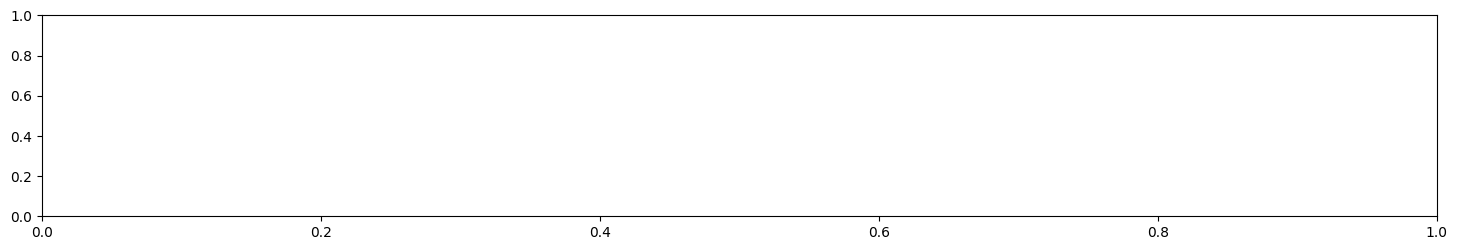

In [13]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(data[-8760:]['timestamp'], data[-8760:]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results['timestamp'][IF_results['isolation_forest'] == 1], IF_results['energy_consumption'][IF_results['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5)
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(data[-8760:]['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(timeseries[IQR_results].index, timeseries[IQR_results], label="IQR", alpha=0.5, color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(data[-8760:]['timestamp'], data['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(LSTM_results['timestamp'][LSTM_results['lstm_autoencoder'] == 1], LSTM_results['energy_consumption'][LSTM_results['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()

plt.subplot(4, 1, 4)
counts_IF = IF_results[IF_results['isolation_forest'] == 1].count()
counts_IQR = timeseries[IQR_results].count()
counts_LSTM = LSTM_results[LSTM_results['lstm_autoencoder'] == 1].count()
plt.bar('Isolation Forest', counts_IF)
plt.bar('IQR', counts_IQR)
plt.bar('LSTM-AE', counts_LSTM)
plt.title('Liczba wykrytych anomalii')

plt.tight_layout()
plt.show()

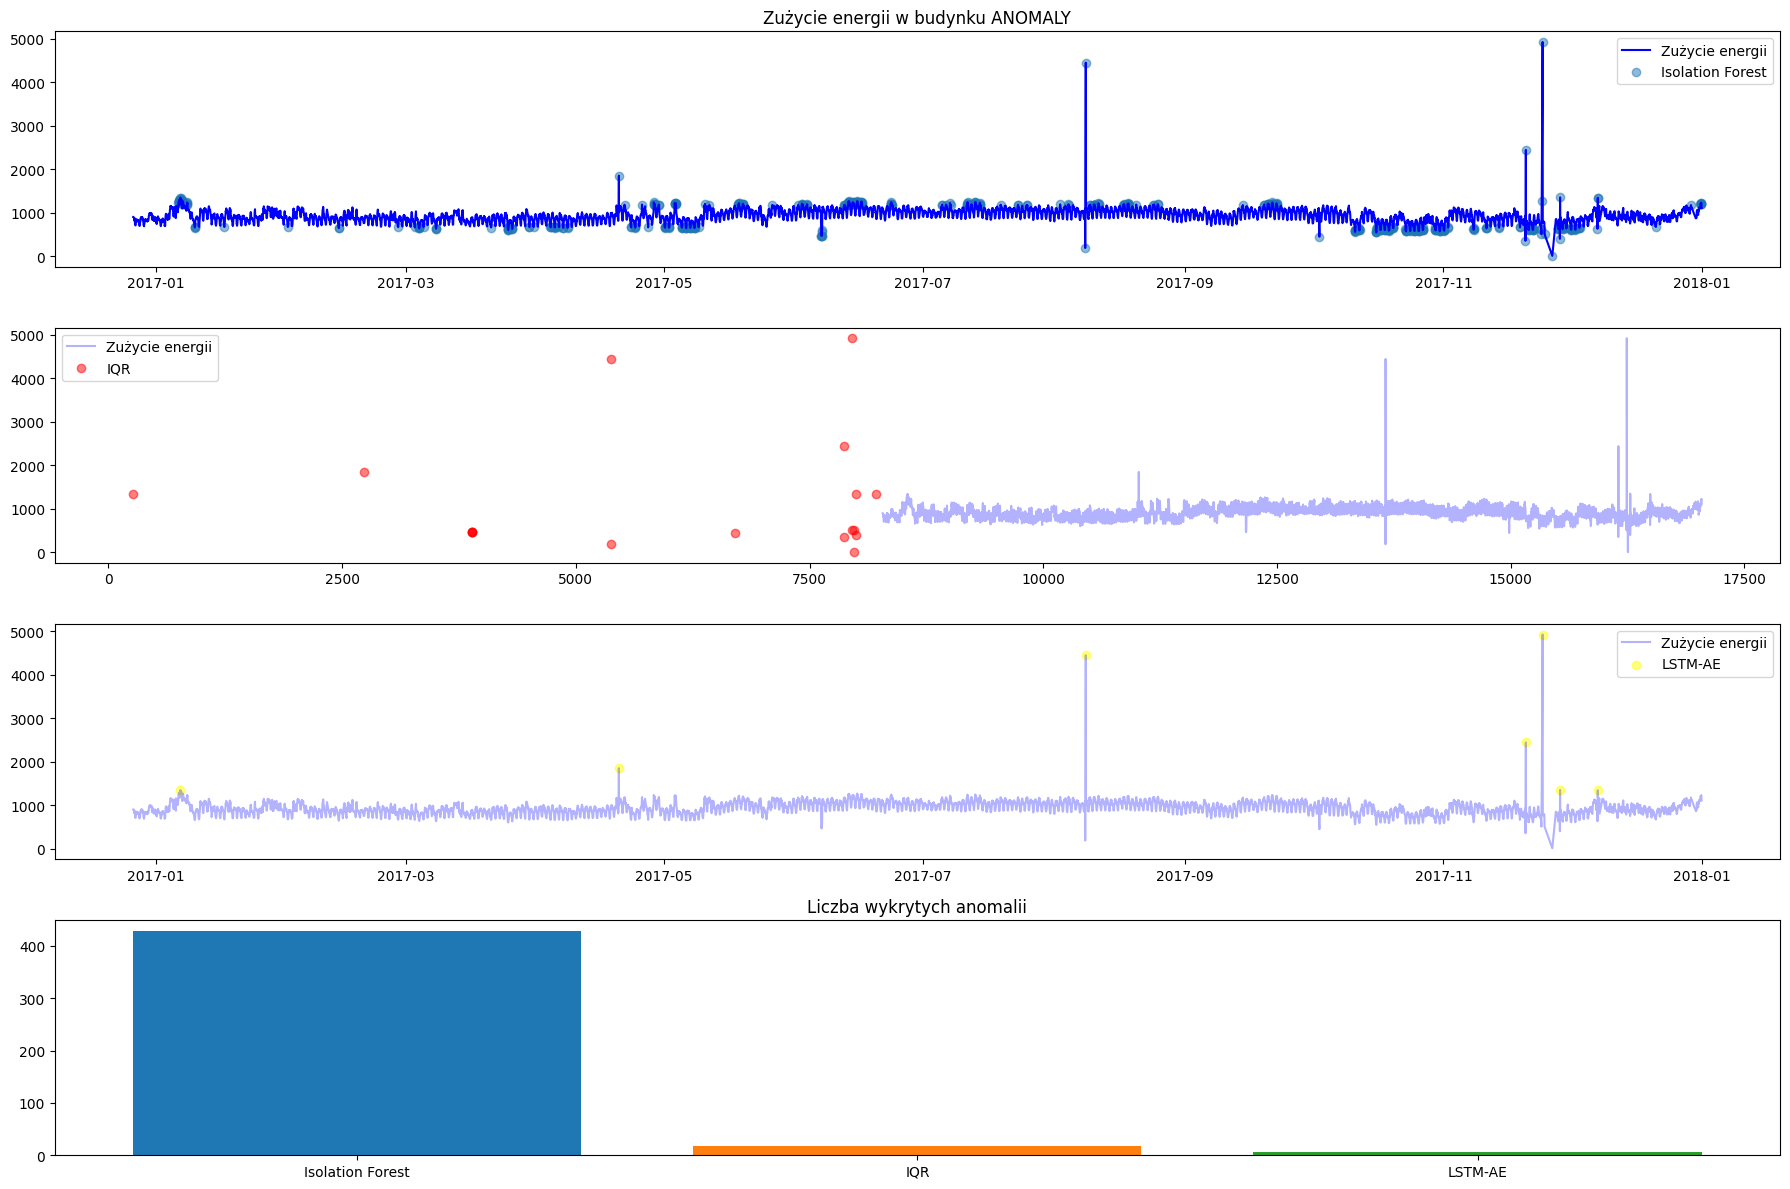

In [ ]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(data['timestamp'], data['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results['timestamp'][IF_results['isolation_forest'] == 1], IF_results['energy_consumption'][IF_results['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5)
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(data['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(timeseries, timeseries[IQR_results], label="IQR", alpha=0.5, color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(data['timestamp'], data['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(LSTM_results['timestamp'][LSTM_results['lstm_autoencoder'] == 1], LSTM_results['energy_consumption'][LSTM_results['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()

plt.subplot(4, 1, 4)
counts_IF = IF_results[IF_results['isolation_forest'] == 1].count()
counts_IQR = timeseries[IQR_results].count()
counts_LSTM = LSTM_results[LSTM_results['lstm_autoencoder'] == 1].count()
plt.bar('Isolation Forest', counts_IF)
plt.bar('IQR', counts_IQR)
plt.bar('LSTM-AE', counts_LSTM)
plt.title('Liczba wykrytych anomalii')

plt.tight_layout()
plt.show()

In [ ]:
print("=========== Wyniki budynek 1 ===========")

c = 0

for i in list(timeseries[IQR_results].index):
    if i in list(data[data['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries[IQR_results].index)) - c}")

c = 0

for i in list(IF_results[IF_results['isolation_forest'] == 1].index):
    if i in list(data[data['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results[IF_results['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(LSTM_results[LSTM_results['lstm_autoencoder'] == 1].index):
    if i in list(data[data['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results[LSTM_results['lstm_autoencoder'] == 1].index)) - c}")


print("=========== Wyniki budynek 2 ===========")

c = 0

for i in list(timeseries2[IQR_results2].index):
    if i in list(data2[data2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries2[IQR_results2].index)) - c}")

c = 0

for i in list(IF_results2[IF_results2['isolation_forest'] == 1].index):
    if i in list(data2[data2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results2[IF_results2['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(LSTM_results2[LSTM_results2['lstm_autoencoder'] == 1].index):
    if i in list(data2[data2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results2[LSTM_results2['lstm_autoencoder'] == 1].index)) - c}")

print("=========== Wyniki budynek 3 ===========")

c = 0

for i in list(timeseries3[IQR_results3].index):
    if i in list(data3[data3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries3[IQR_results3].index)) - c}")

c = 0

for i in list(IF_results3[IF_results3['isolation_forest'] == 1].index):
    if i in list(data3[data3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results3[IF_results3['isolation_forest'] == 1].index)) - c}")
c = 0


for i in list(LSTM_results3[LSTM_results3['lstm_autoencoder'] == 1].index):
    if i in list(data3[data3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results3[LSTM_results3['lstm_autoencoder'] == 1].index)) - c}")

=========== Wyniki budynek 1 ===========


NameError: name 'timeseries' is not defined

--- ANOMALY 1

Liczba anomalii wykrytych przez IQR: 24/39\
Liczba anomalii wykrytych przez IQR spoza zakresu: 9\
Liczba anomalii wykrytych przez IF: 39/39\
Liczba anomalii wykrytych przez IF spoza zakresu: 131\
Liczba anomalii wykrytych przez LSTM-AE: 36/39\
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 439

--- ANOMALY 2

Liczba anomalii wykrytych przez IQR: 20/51\
Liczba anomalii wykrytych przez IQR spoza zakresu: 0\
Liczba anomalii wykrytych przez IF: 51/51\
Liczba anomalii wykrytych przez IF spoza zakresu: 70\
Liczba anomalii wykrytych przez LSTM-AE: 49/51\
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 579

--- ANOMALY 3

Liczba anomalii wykrytych przez IQR: 38/62\
Liczba anomalii wykrytych przez IQR spoza zakresu: 8\
Liczba anomalii wykrytych przez IF: 62/62\
Liczba anomalii wykrytych przez IF spoza zakresu: 54\
Liczba anomalii wykrytych przez LSTM-AE: 49/62\
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 796

### Wyniki dla ostatniego roku
=========== Wyniki budynek 1 ===========
Liczba anomalii wykrytych przez IQR: 39/39
Liczba anomalii wykrytych przez IQR spoza zakresu: 3
Liczba anomalii wykrytych przez IF: 39/39
Liczba anomalii wykrytych przez IF spoza zakresu: 799
Liczba anomalii wykrytych przez LSTM-AE: 4/39
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 3
=========== Wyniki budynek 2 ===========
Liczba anomalii wykrytych przez IQR: 45/51
Liczba anomalii wykrytych przez IQR spoza zakresu: 17
Liczba anomalii wykrytych przez IF: 51/51
Liczba anomalii wykrytych przez IF spoza zakresu: 552
Liczba anomalii wykrytych przez LSTM-AE: 24/51
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 7
=========== Wyniki budynek 3 ===========
Liczba anomalii wykrytych przez IQR: 60/62
Liczba anomalii wykrytych przez IQR spoza zakresu: 88
Liczba anomalii wykrytych przez IF: 62/62
Liczba anomalii wykrytych przez IF spoza zakresu: 330
Liczba anomalii wykrytych przez LSTM-AE: 29/62
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 88




In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

data = [
    ("IQR", "I", 34, 5, 132, 16871),
    ("IQR", "II", 30, 21, 10, 11999),
    ("IQR", "III", 50, 12, 40, 7721),
    ("IF z percentylem 0.95", "I", 39, 0, 802, 16201),
    ("IF z percentylem 0.95", "II", 51, 0, 549, 11460),
    ("IF z percentylem 0.95", "III", 62, 0, 330, 7431),

    ("IF z IQR", "I", 38, 1, 3, 12018),
    ("IF z IQR", "II", 44, 7, 17, 11992),
    ("IF z IQR", "III", 62, 0, 85, 7676),
    
    ("LSTM-AE", "I", 38, 1, 761, 16242),
    ("LSTM-AE", "II", 50, 1, 819, 11190),
    ("LSTM-AE", "III", 49, 13, 769, 6992),
]

df = pd.DataFrame(data, columns=["Model", "Budynek", "TP", "FN", "FP", "TN"])

df["Precision"] = df["TP"] / (df["TP"] + df["FP"])
df["Recall"] = df["TP"] / (df["TP"] + df["FN"])
df["F1-score"] = 2 * df["Precision"] * df["Recall"] / (df["Precision"] + df["Recall"])
df["Accuracy"] = (df["TP"] + df["TN"]) / (df["TP"] + df["TN"] + df["FP"] + df["FN"])

df_metrics_1 = df[["Model", "Budynek", "Precision", "Recall", "F1-score", "Accuracy"]].round(4)
df_metrics_1

,Model,Budynek,Precision,Recall,F1-score,Accuracy
0,IQR,I,0.2048,0.8718,0.3317,0.9920
1,IQR,II,0.7500,0.5882,0.6593,0.9974
2,IQR,III,0.5556,0.8065,0.6579,0.9934
3,IF z percentylem 0.95,I,0.0464,1.0000,0.0886,0.9529
4,IF z percentylem 0.95,II,0.0850,1.0000,0.1567,0.9545
5,IF z percentylem 0.95,III,0.1582,1.0000,0.2731,0.9578
6,IF z IQR,I,0.9268,0.9744,0.9500,0.9997
7,IF z IQR,II,0.7213,0.8627,0.7857,0.9980
8,IF z IQR,III,0.4218,1.0000,0.5933,0.9891
9,LSTM-AE,I,0.0476,0.9744,0.0907,0.9553


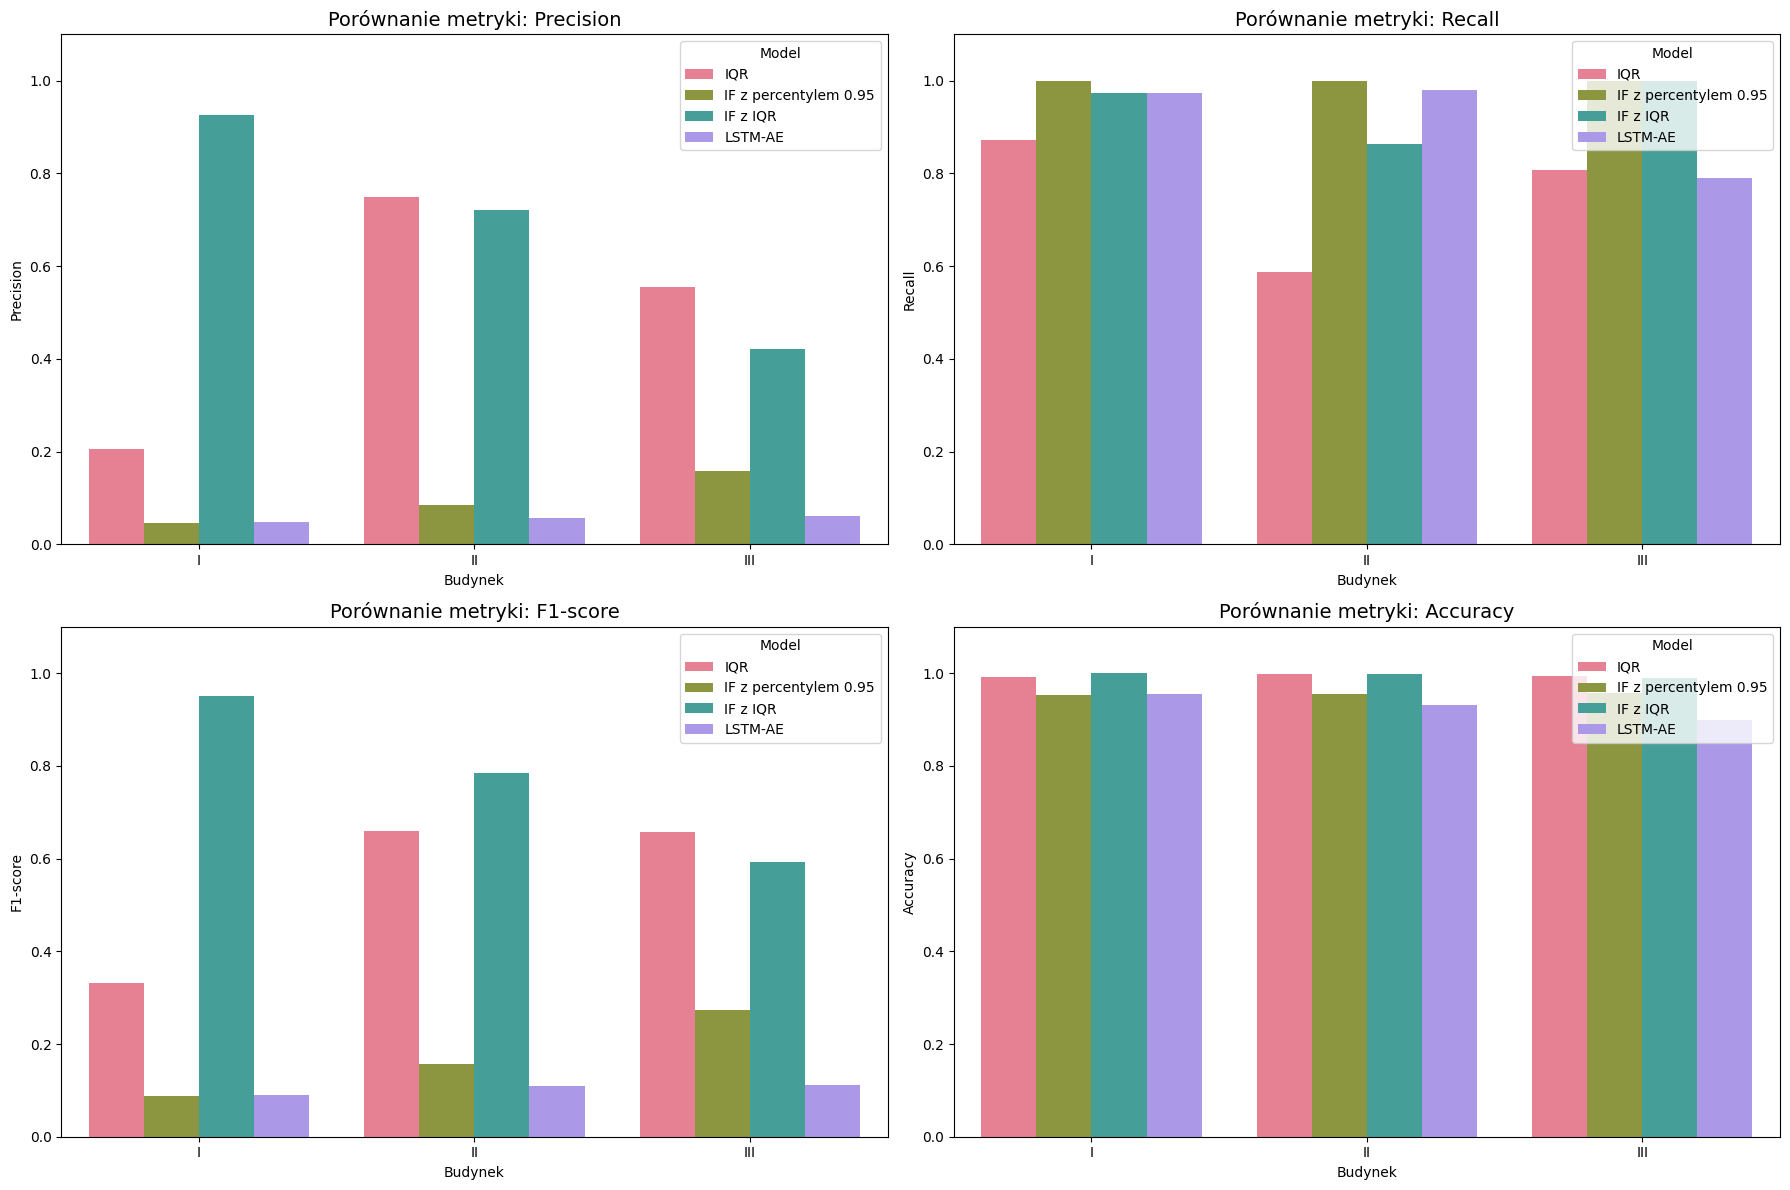

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df1 = pd.DataFrame(df_metrics_1, columns=['Model', 'Budynek', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
df1['Tabela'] = 'Tabela 1'

metrics = ['Precision', 'Recall', 'F1-score', 'Accuracy']
unique_models = df1['Model'].unique()
palette = sns.color_palette("husl", len(unique_models))
model_colors = dict(zip(unique_models, palette))

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    df_sorted = df1.copy()
    df_sorted['sort_key'] = df_sorted.groupby('Budynek')[metric].rank(ascending=False, method='first')
    df_sorted = df_sorted.sort_values(by=['Budynek', 'sort_key'])
    df_sorted.reset_index(drop=True, inplace=True)
    
    sns.barplot(
        data=df_sorted,
        x='Budynek',
        y=metric,
        hue='Model',
        ax=ax,
        errorbar=None,
        dodge=True,
        palette=model_colors,
        hue_order=unique_models
    )
    
    ax.set_title(f'Porównanie metryki: {metric}', fontsize=14)
    ax.set_ylabel(metric)
    ax.set_xlabel('Budynek')
    ax.set_ylim(0, 1.1)
    ax.tick_params(axis='x', rotation=0)
    ax.legend(title='Model')

plt.tight_layout()
plt.show()

### Z oknami, ROK

In [41]:
print("=========== Wyniki budynek 1 ===========")

c = 0

for i in list(timeseriesW[IQR_resultsW].index):
    if i in list(dataW[dataW['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(dataW[dataW['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseriesW[IQR_resultsW].index)) - c}")

c = 0

for i in list(IF_resultsW[IF_resultsW['isolation_forest'] == 1].index):
    if i in list(dataW[dataW['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(dataW[dataW['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_resultsW[IF_resultsW['isolation_forest'] == 1].index)) - c}")

c = 0

for i in list(LSTM_resultsW[LSTM_resultsW['lstm_autoencoder'] == 1].index):
    if i in list(dataW[dataW['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(dataW[dataW['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_resultsW[LSTM_resultsW['lstm_autoencoder'] == 1].index)) - c}")


print("=========== Wyniki budynek 2 ===========")

c = 0

for i in list(timeseries2W[IQR_results2W].index):
    if i in list(data2W[data2W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data2W[data2W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries2W[IQR_results2W].index)) - c}")

c = 0

for i in list(IF_results2W[IF_results2W['isolation_forest'] == 1].index):
    if i in list(data2W[data2W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data2W[data2W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results2W[IF_results2W['isolation_forest'] == 1].index)) - c}")

c = 0

for i in list(LSTM_results2W[LSTM_results2W['lstm_autoencoder'] == 1].index):
    if i in list(data2W[data2W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data2W[data2W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results2W[LSTM_results2W['lstm_autoencoder'] == 1].index)) - c}")

print("=========== Wyniki budynek 3 ===========")

c = 0

for i in list(timeseries3W[IQR_results3W].index):
    if i in list(data3W[data3W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data3W[data3W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries3W[IQR_results3W].index)) - c}")

c = 0

for i in list(IF_results3W[IF_results3W['isolation_forest'] == 1].index):
    if i in list(data3W[data3W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data3W[data3W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results3W[IF_results3W['isolation_forest'] == 1].index)) - c}")
c = 0

for i in list(LSTM_results3W[LSTM_results3W['lstm_autoencoder'] == 1].index):
    if i in list(data3W[data3W['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data3W[data3W['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results3W[LSTM_results3W['lstm_autoencoder'] == 1].index)) - c}")

=========== Wyniki budynek 1 ===========
Liczba anomalii wykrytych przez IQR: 0/16
Liczba anomalii wykrytych przez IQR spoza zakresu: 81
Liczba anomalii wykrytych przez IF: 0/16
Liczba anomalii wykrytych przez IF spoza zakresu: 17
Liczba anomalii wykrytych przez LSTM-AE: 15/16
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 592
=========== Wyniki budynek 2 ===========
Liczba anomalii wykrytych przez IQR: 0/47
Liczba anomalii wykrytych przez IQR spoza zakresu: 34
Liczba anomalii wykrytych przez IF: 7/47
Liczba anomalii wykrytych przez IF spoza zakresu: 28
Liczba anomalii wykrytych przez LSTM-AE: 45/47
Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: 388
=========== Wyniki budynek 3 ===========
Liczba anomalii wykrytych przez IQR: 50/62
Liczba anomalii wykrytych przez IQR spoza zakresu: 40
Liczba anomalii wykrytych przez IF: 2/62
Liczba anomalii wykrytych przez IF spoza zakresu: 136
Liczba anomalii wykrytych przez LSTM-AE: 55/62
Liczba anomalii wykrytych przez LSTM-AE spoza 

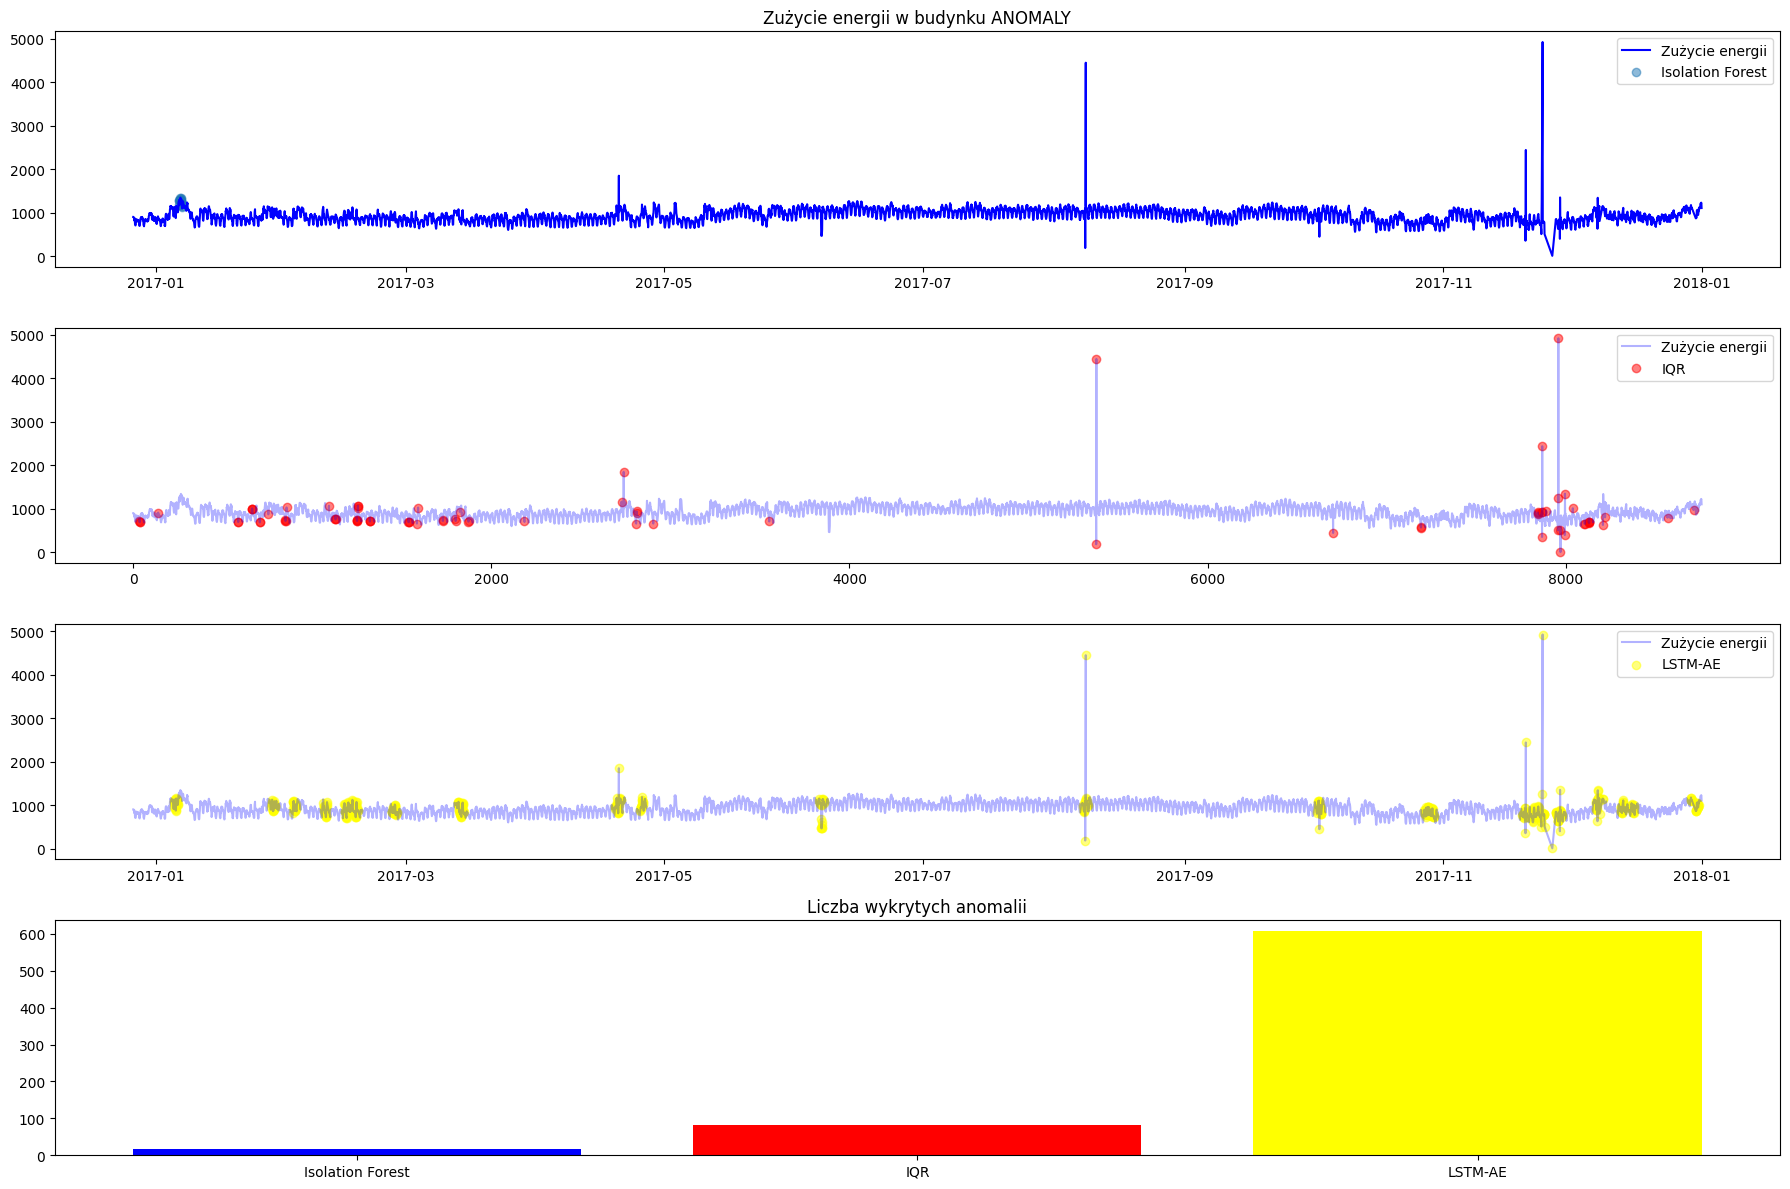

In [43]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(dataW['timestamp'], dataW['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_resultsW['timestamp'][IF_resultsW['isolation_forest'] == 1], IF_resultsW['energy_consumption'][IF_resultsW['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5)
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(timeseriesW, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(timeseriesW[IQR_resultsW].index, timeseriesW[IQR_resultsW], label="IQR", alpha=0.5, color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(dataW['timestamp'], dataW['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(LSTM_resultsW['timestamp'][LSTM_resultsW['lstm_autoencoder'] == 1], LSTM_resultsW['energy_consumption'][LSTM_resultsW['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()

plt.subplot(4, 1, 4)
counts_IFW = IF_resultsW[IF_resultsW['isolation_forest'] == 1].count()
counts_IQRW = timeseriesW[IQR_resultsW].count()
counts_LSTMW = LSTM_resultsW[LSTM_resultsW['lstm_autoencoder'] == 1].count()
plt.bar('Isolation Forest', counts_IFW,color='blue')
plt.bar('IQR', counts_IQRW, color='red')
plt.bar('LSTM-AE', counts_LSTMW, color='yellow')
plt.title('Liczba wykrytych anomalii')

plt.tight_layout()
plt.show()

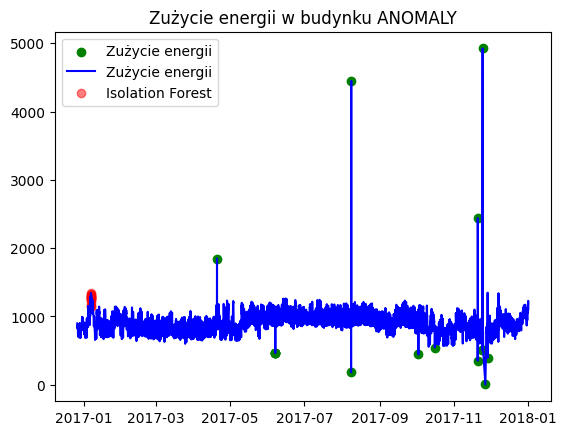

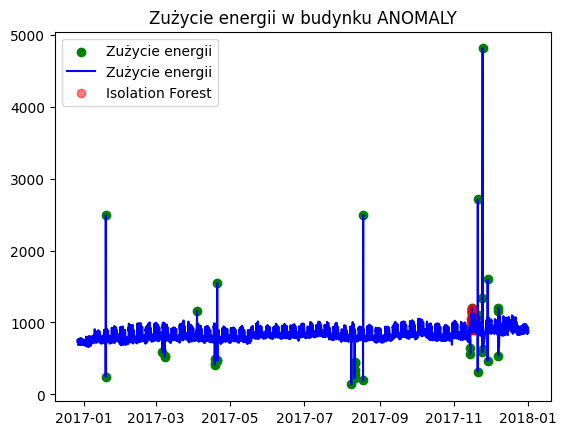

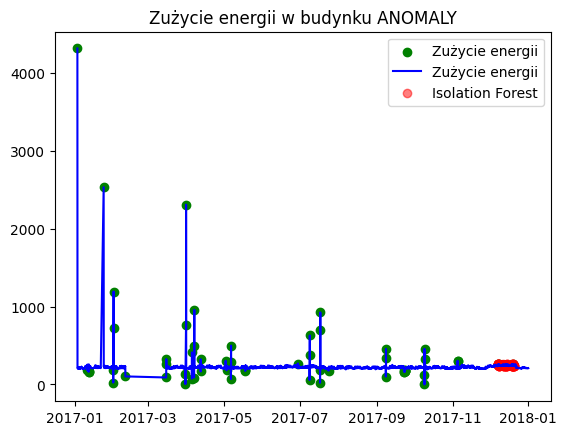

In [56]:
plt.scatter(dataW[dataW['anomaly'] == True]['timestamp'], dataW[dataW['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(dataW['timestamp'], dataW['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_resultsW['timestamp'][IF_resultsW['isolation_forest'] == 1], IF_resultsW['energy_consumption'][IF_resultsW['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()

plt.scatter(data2W[data2W['anomaly'] == True]['timestamp'], data2W[data2W['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(data2W['timestamp'], data2W['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results2W['timestamp'][IF_results2W['isolation_forest'] == 1], IF_results2W['energy_consumption'][IF_results2W['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()

plt.scatter(data3W[data3W['anomaly'] == True]['timestamp'], data3W[data3W['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(data3W['timestamp'], data3W['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results3W['timestamp'][IF_results3W['isolation_forest'] == 1], IF_results3W['energy_consumption'][IF_results3W['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()


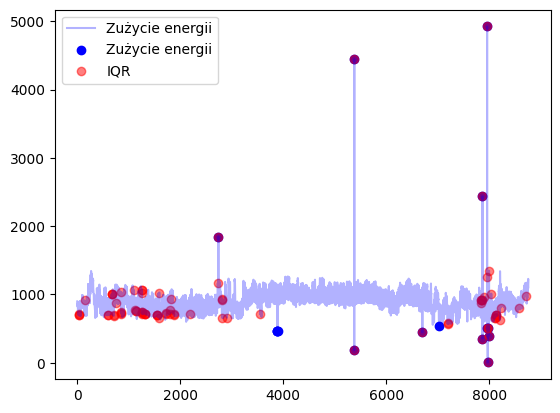

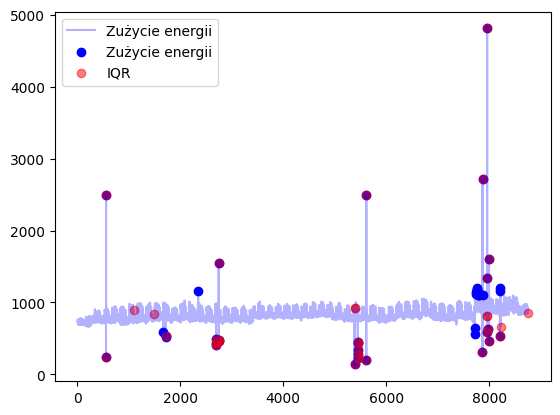

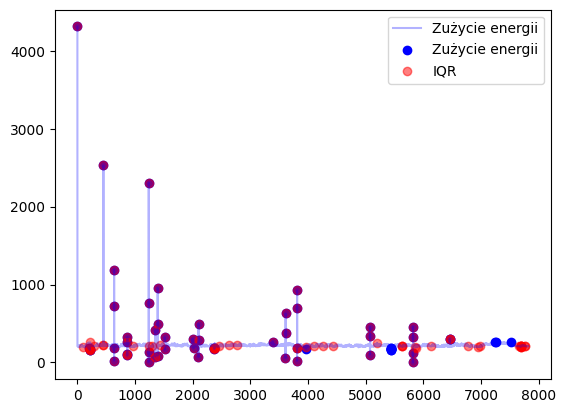

In [90]:
temp = dataW.reset_index().drop(columns=['index'])
temp2 = data2W.reset_index().drop(columns=['index'])
temp3 = data3W.reset_index().drop(columns=['index'])

plt.plot(timeseriesW, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(temp[temp['anomaly'] == True].index, temp[temp['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseriesW[IQR_resultsW].index, timeseriesW[IQR_resultsW], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()

plt.plot(timeseries2W, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(temp2[temp2['anomaly'] == True].index, temp2[temp2['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseries2W[IQR_results2W].index, timeseries2W[IQR_results2W], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()

plt.plot(timeseries3W, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(temp3[temp3['anomaly'] == True].index, temp3[temp3['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseries3W[IQR_results3W].index, timeseries3W[IQR_results3W], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()



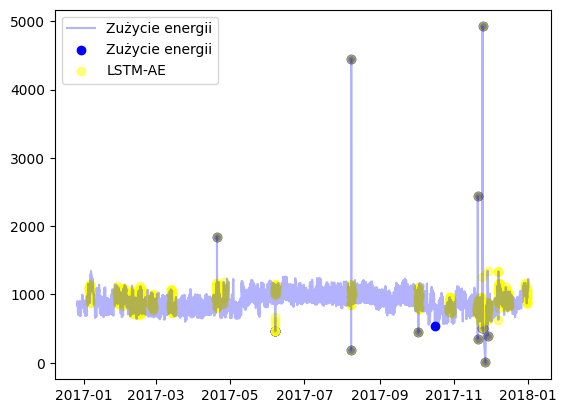

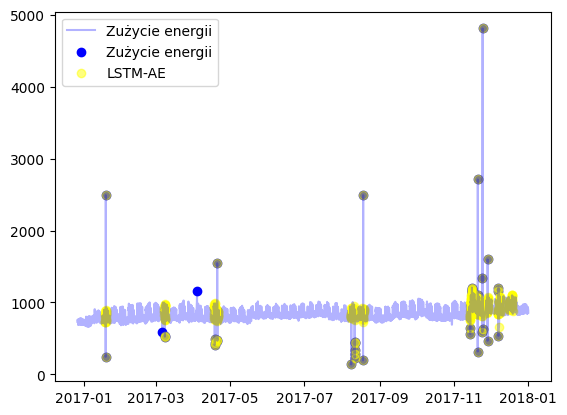

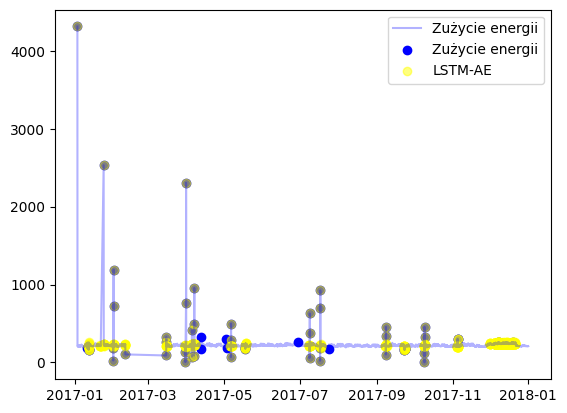

In [65]:

plt.plot(dataW['timestamp'], dataW['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(dataW[dataW['anomaly'] == True]['timestamp'], dataW[dataW['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(LSTM_resultsW['timestamp'][LSTM_resultsW['lstm_autoencoder'] == 1], LSTM_resultsW['energy_consumption'][LSTM_resultsW['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()
plt.show()

plt.plot(data2W['timestamp'], data2W['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(data2W[data2W['anomaly'] == True]['timestamp'], data2W[data2W['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(LSTM_results2W['timestamp'][LSTM_results2W['lstm_autoencoder'] == 1], LSTM_results2W['energy_consumption'][LSTM_results2W['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()
plt.show()

plt.plot(data3W['timestamp'], data3W['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(data3W[data3W['anomaly'] == True]['timestamp'], data3W[data3W['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(LSTM_results3W['timestamp'][LSTM_results3W['lstm_autoencoder'] == 1], LSTM_results3W['energy_consumption'][LSTM_results3W['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='yellow')
plt.legend()
plt.show()

### Bez okien, ROK

In [103]:
data = load_and_preprocess('anomaly_one_marked.csv')[-8760:]
data_lstm = data
IF_results = isolation_forest_IQR(data=data)
IF_95_results = isolation_forest_95(data=data)
# LSTM_results = lstm_autoencoder(data_lstm, window_size=None)
timeseries, IQR_results = dynamic_iqr(data['energy_consumption'], w=None, k=1.5)

In [104]:
data2 = load_and_preprocess('anomaly_two_marked.csv')[-8760:]
data_lstm2 = data2
IF_results2 = isolation_forest_IQR(data=data2)
IF_95_results2 = isolation_forest_95(data=data2)
#LSTM_results2 = lstm_autoencoder(data_lstm2, window_size=None)
timeseries2, IQR_results2 = dynamic_iqr(data2['energy_consumption'], w=None, k=1.5)


data3 = load_and_preprocess('anomaly_three_marked.csv')[-8760:]
data_lstm3 = data3
IF_results3 = isolation_forest_IQR(data=data3)
IF_95_results3 = isolation_forest_95(data=data3)
#LSTM_results3 = lstm_autoencoder(data_lstm3, window_size=None)
timeseries3, IQR_results3 = dynamic_iqr(data3['energy_consumption'], w=None, k=1.5)

In [105]:
tempN = data.reset_index().drop(columns=['index'])
temp2N = data2.reset_index().drop(columns=['index'])
temp3N = data3.reset_index().drop(columns=['index'])

print("=========== Wyniki budynek 1 ===========")

c = 0

for i in list(timeseries[IQR_results].index):
    if i in list(tempN[tempN['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries[IQR_results].index)) - c}")

c = 0

for i in list(IF_results[IF_results['isolation_forest'] == 1].index):
    if i in list(data[data['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data[data['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results[IF_results['isolation_forest'] == 1].index)) - c}")
c = 0

# for i in list(LSTM_results[LSTM_results['lstm_autoencoder'] == 1].index):
#     if i in list(data[data['anomaly'] == True].index):
#         c+=1

# print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data[data['anomaly'] == True].index)}")
# print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results[LSTM_results['lstm_autoencoder'] == 1].index)) - c}")


print("=========== Wyniki budynek 2 ===========")

c = 0

for i in list(timeseries2[IQR_results2].index):
    if i in list(temp2N[temp2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries2[IQR_results2].index)) - c}")

c = 0

for i in list(IF_results2[IF_results2['isolation_forest'] == 1].index):
    if i in list(data2[data2['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data2[data2['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results2[IF_results2['isolation_forest'] == 1].index)) - c}")
c = 0

# for i in list(LSTM_results2[LSTM_results2['lstm_autoencoder'] == 1].index):
#     if i in list(data2[data2['anomaly'] == True].index):
#         c+=1

# print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data2[data2['anomaly'] == True].index)}")
# print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results2[LSTM_results2['lstm_autoencoder'] == 1].index)) - c}")

print("=========== Wyniki budynek 3 ===========")

c = 0

for i in list(timeseries3[IQR_results3].index):
    if i in list(temp3N[temp3N['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(timeseries3[IQR_results3].index)) - c}")

c = 0

for i in list(IF_results3[IF_results3['isolation_forest'] == 1].index):
    if i in list(data3[data3['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IF: {c}/{len(data3[data3['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IF spoza zakresu: {len(list(IF_results3[IF_results3['isolation_forest'] == 1].index)) - c}")
c = 0


# for i in list(LSTM_results3[LSTM_results3['lstm_autoencoder'] == 1].index):
#     if i in list(data3[data3['anomaly'] == True].index):
#         c+=1

# print(f"Liczba anomalii wykrytych przez LSTM-AE: {c}/{len(data3[data3['anomaly'] == True].index)}")
# print(f"Liczba anomalii wykrytych przez LSTM-AE spoza zakresu: {len(list(LSTM_results3[LSTM_results3['lstm_autoencoder'] == 1].index)) - c}")

=========== Wyniki budynek 1 ===========
Liczba anomalii wykrytych przez IQR: 15/16
Liczba anomalii wykrytych przez IQR spoza zakresu: 3
Liczba anomalii wykrytych przez IF: 16/16
Liczba anomalii wykrytych przez IF spoza zakresu: 403
=========== Wyniki budynek 2 ===========
Liczba anomalii wykrytych przez IQR: 45/47
Liczba anomalii wykrytych przez IQR spoza zakresu: 7
Liczba anomalii wykrytych przez IF: 47/47
Liczba anomalii wykrytych przez IF spoza zakresu: 389
=========== Wyniki budynek 3 ===========
Liczba anomalii wykrytych przez IQR: 60/62
Liczba anomalii wykrytych przez IQR spoza zakresu: 88
Liczba anomalii wykrytych przez IF: 62/62
Liczba anomalii wykrytych przez IF spoza zakresu: 329


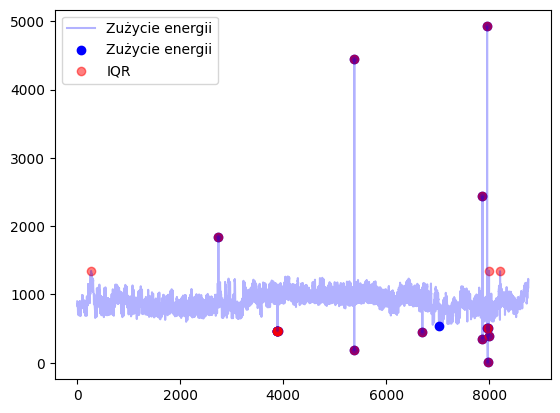

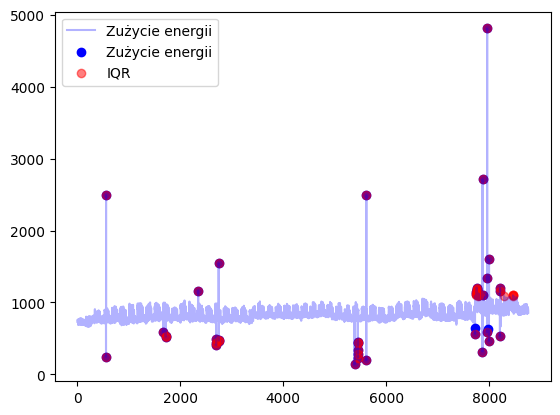

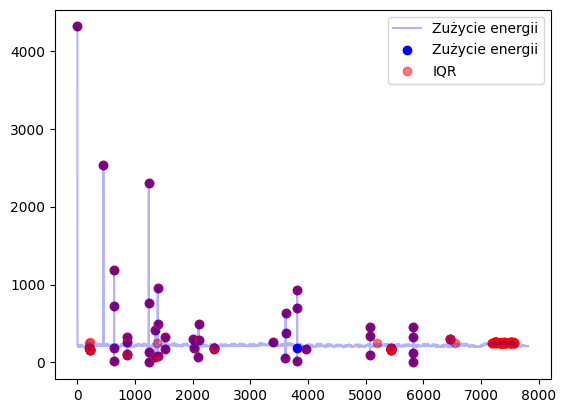

In [106]:
plt.plot(timeseries, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(tempN[tempN['anomaly'] == True].index, tempN[tempN['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseriesW[IQR_results].index, timeseriesW[IQR_results], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()

plt.plot(timeseries2, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(temp2N[temp2N['anomaly'] == True].index, temp2N[temp2N['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseries2[IQR_results2].index, timeseries2[IQR_results2], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()

plt.plot(timeseries3, label='Zużycie energii', color='blue', alpha=0.3)
plt.scatter(temp3N[temp3N['anomaly'] == True].index, temp3N[temp3N['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(timeseries3[IQR_results3].index, timeseries3[IQR_results3], label="IQR", alpha=0.5, color='red')
plt.legend()
plt.show()



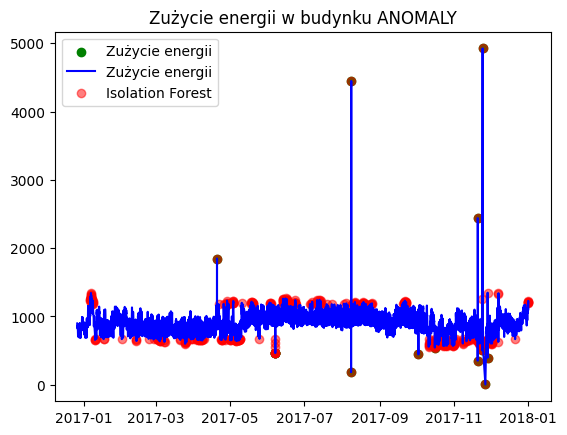

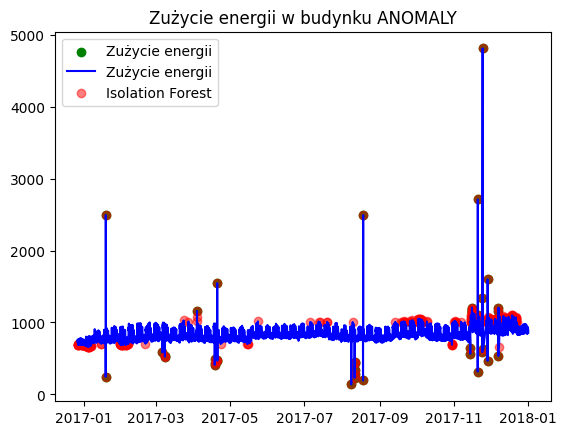

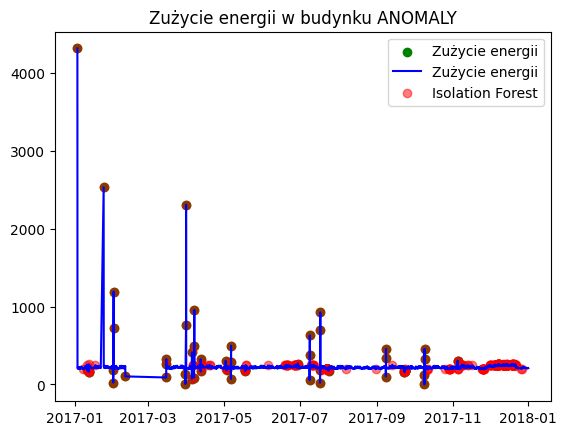

In [107]:
plt.scatter(data[data['anomaly'] == True]['timestamp'], data[data['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(data['timestamp'], data['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results['timestamp'][IF_results['isolation_forest'] == 1], IF_results['energy_consumption'][IF_results['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()

plt.scatter(data2[data2['anomaly'] == True]['timestamp'], data2[data2['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(data2['timestamp'], data2['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results2['timestamp'][IF_results2['isolation_forest'] == 1], IF_results2['energy_consumption'][IF_results2['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()

plt.scatter(data3[data3['anomaly'] == True]['timestamp'], data3[data3['anomaly'] == True]['energy_consumption'], label='Zużycie energii', color='green')
plt.plot(data3['timestamp'], data3['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(IF_results3['timestamp'][IF_results3['isolation_forest'] == 1], IF_results3['energy_consumption'][IF_results3['isolation_forest'] == 1],label="Isolation Forest", alpha=0.5, c="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()
plt.show()


### WYBÓR MODELI

In [8]:
d = load_and_preprocess('anomaly_one_marked.csv')
d = d.set_index("timestamp")
d_lstm = d
resIF = isolation_forest_IQR(data=d)
resLSTM = lstm_autoencoder(d_lstm, window_size=24, iqr_multiplier=4.5)
t, resIQR = dynamic_iqr(d['energy_consumption'], w=None, k=1.5)

d2 = load_and_preprocess('anomaly_two_marked.csv')
d2 = d2.set_index("timestamp")
d_lstm2 = d2
resIF2 = isolation_forest_IQR(data=d2)
resLSTM2 = lstm_autoencoder(d_lstm2, window_size=24, iqr_multiplier=4.5)
t2, resIQR2 = dynamic_iqr(d2['energy_consumption'], w=None, k=1.5)

d3 = load_and_preprocess('anomaly_three_marked.csv')
d3 = d3.set_index("timestamp")
d_lstm3 = d3
resIF3 = isolation_forest_IQR(data=d3)
resLSTM3 = lstm_autoencoder(d_lstm3, window_size=24, iqr_multiplier=4.5)
t3, resIQR3 = dynamic_iqr(d3['energy_consumption'], w=None, k=1.5)

Reloading Tuner from tuning\energy_forecast\tuner0.json



c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


426/426 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - loss: 1.5322e-04 - mae: 0.0048 - val_loss: 1.4791e-04 - val_mae: 0.0044
Epoch 2/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 1.5821e-04 - mae: 0.0047 - val_loss: 1.4332e-04 - val_mae: 0.0044
Epoch 3/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 1.5658e-04 - mae: 0.0047 - val_loss: 1.4398e-04 - val_mae: 0.0046
Epoch 4/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 1.6225e-04 - mae: 0.0047 - val_loss: 1.4313e-04 - val_mae: 0.0045
Epoch 5/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - loss: 1.3042e-04 - mae: 0.0045 - val_loss: 1.3768e-04 - val_mae: 0.0044
Epoch 6/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - loss: 1.5060e-04 - mae: 0.0046 - val_loss: 1.4781e-04 - val_mae: 0.0049
Epoch 7/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 1.5520e-04 - mae: 0.0047 - val_loss: 1.4607e-04 - val_mae: 0.0047
Epoch 8/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - loss: 1.7151e-04 - mae: 0.0047 - val_loss: 1.4277e-04 - val

c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - loss: 3.4274e-05 - mae: 0.0032 - val_loss: 1.2208e-04 - val_mae: 0.0027
Epoch 2/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - loss: 2.0530e-05 - mae: 0.0023 - val_loss: 1.6528e-04 - val_mae: 0.0034
Epoch 3/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 0.0458 - mae: 0.0035 - val_loss: 3.4237e-04 - val_mae: 0.0115
Epoch 4/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 1.0163e-04 - mae: 0.0078 - val_loss: 3.0539e-04 - val_mae: 0.0104
Epoch 5/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 9.3920e-05 - mae: 0.0072 - val_loss: 2.6120e-04 - val_mae: 0.0091
Epoch 6/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 8.4852e-05 - mae: 0.0065 - val_loss: 2.4733e-04 - val_mae: 0.0085
Epoch 7/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 7.2868e-05 - mae: 0.0060 - val_loss: 2.4280e-04 - val_mae: 0.0081
Epoch 8/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 7.0959e-05 - mae: 0.0057 - val_loss: 2.3322e-0

c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


195/195 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 2.0551e-04 - mae: 0.0081 - val_loss: 1.0751e-05 - val_mae: 0.0026
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 1.0700e-04 - mae: 0.0036 - val_loss: 2.9169e-06 - val_mae: 0.0012
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 1.0760e-04 - mae: 0.0029 - val_loss: 1.8382e-06 - val_mae: 9.0125e-04
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 8.1008e-05 - mae: 0.0024 - val_loss: 2.3114e-06 - val_mae: 0.0011
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 8.4558e-05 - mae: 0.0023 - val_loss: 3.0027e-06 - val_mae: 0.0013
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 9.3867e-05 - mae: 0.0026 - val_loss: 6.5148e-06 - val_mae: 0.0021
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 9.5692e-05 - mae: 0.0023 - val_loss: 4.2480e-06 - val_mae: 0.0016
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 9.8738e-05 - mae: 0.0022 - val_loss: 2.7191e-06 - val_ma

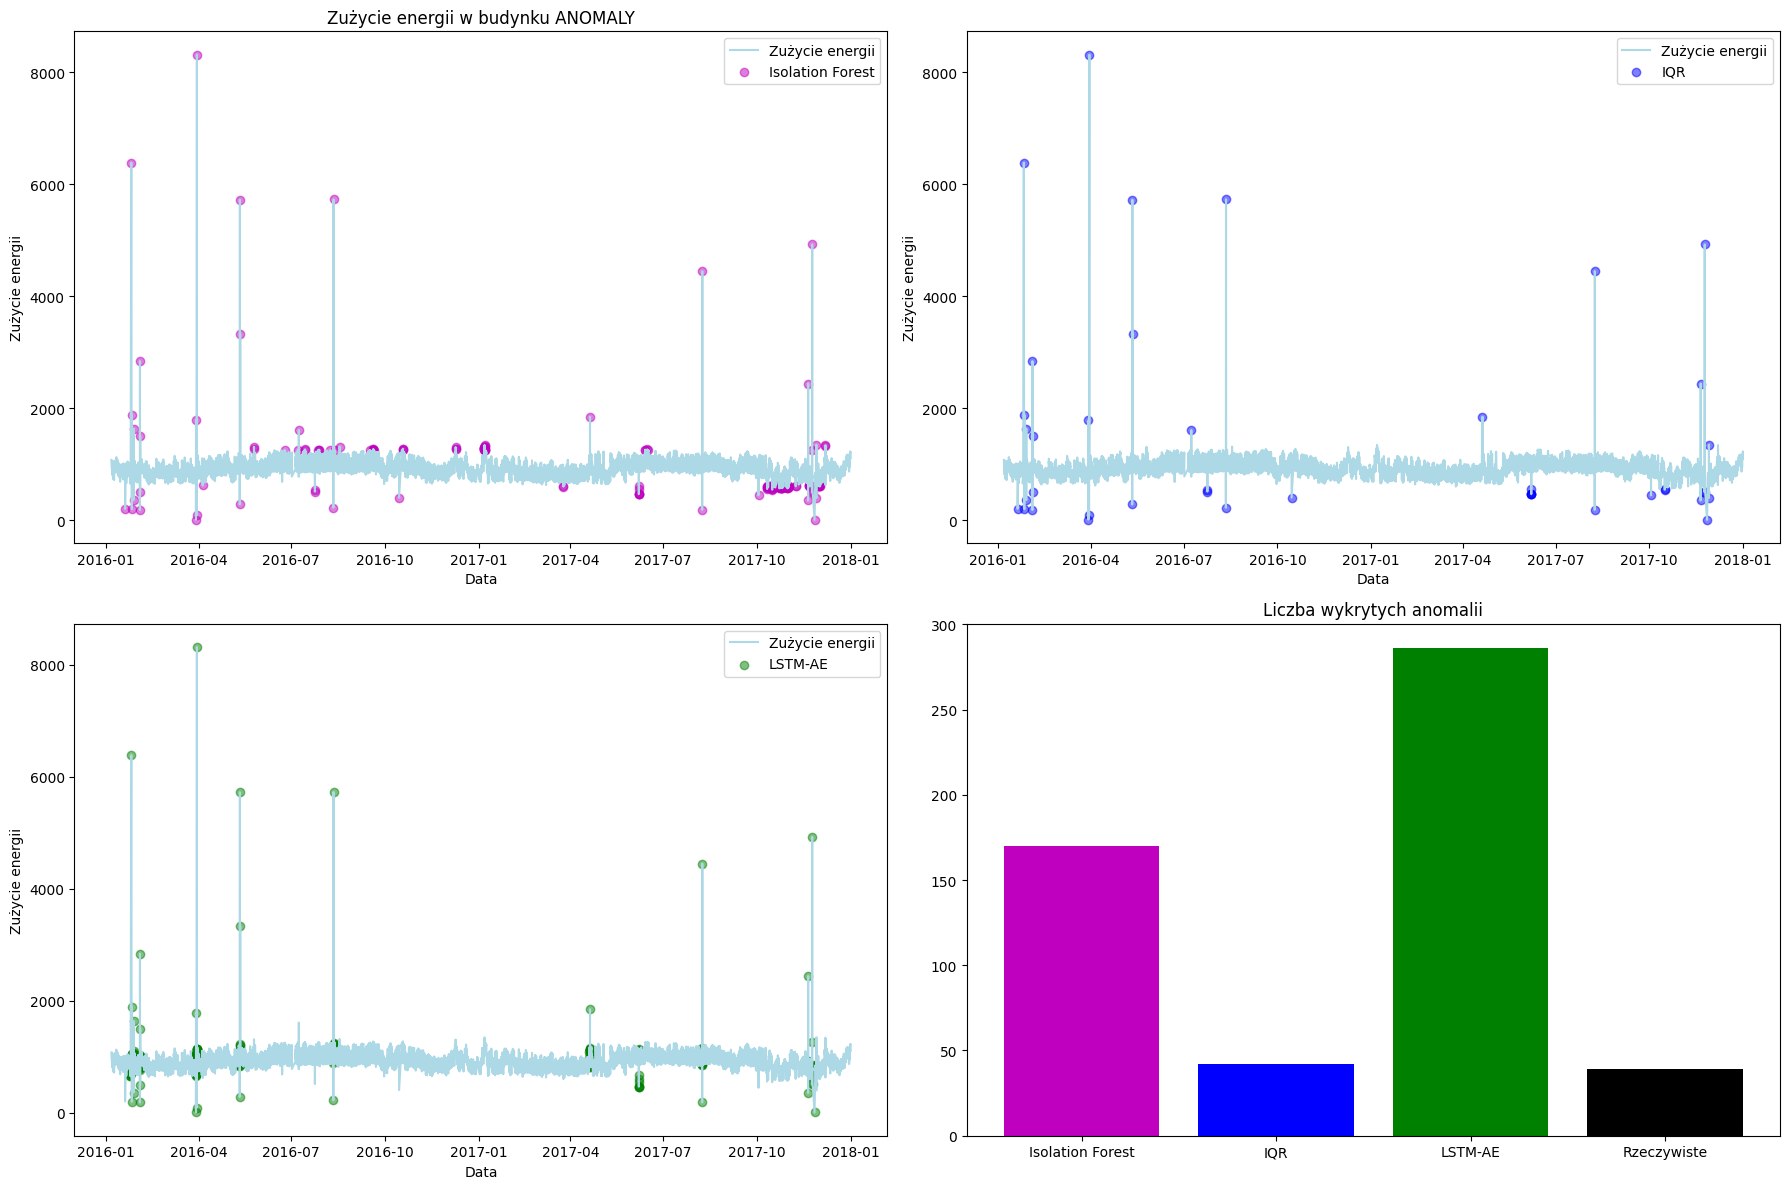

In [41]:
def plots(data, IF, LSTM, IQR):
    plt.figure(figsize=(18, 12))

    plt.subplot(2, 2, 1)
    plt.plot(data.index, data['energy_consumption'], label='Zużycie energii', color='lightblue')
    plt.scatter(IF.index[IF['isolation_forest'] == 1], IF['energy_consumption'][IF['isolation_forest'] == 1], color="m", label="Isolation Forest", alpha=0.5)
    plt.title(f'Zużycie energii w budynku ANOMALY')
    plt.ylabel("Zużycie energii")
    plt.xlabel("Data")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(data.index, data['energy_consumption'], label='Zużycie energii', color='lightblue')
    plt.scatter(data[IQR].index, data[IQR]['energy_consumption'], label="IQR", alpha=0.5, color='blue')
    plt.ylabel("Zużycie energii")
    plt.xlabel("Data")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(data.index, data['energy_consumption'], label='Zużycie energii', color='lightblue')
    plt.scatter(LSTM.index[LSTM['lstm_autoencoder'] == 1], LSTM['energy_consumption'][LSTM['lstm_autoencoder'] == 1], label="LSTM-AE", alpha=0.5, color='green')
    plt.ylabel("Zużycie energii")
    plt.xlabel("Data")
    plt.legend()

    plt.subplot(2, 2, 4)
    counts_IF = IF[IF['isolation_forest'] == 1].count()
    counts_IQR = data[IQR].count()
    counts_LSTM = LSTM[LSTM['lstm_autoencoder'] == 1].count()
    counts_real = data[data['anomaly']==True].count()
    plt.bar('Isolation Forest', counts_IF,color='m')
    plt.bar('IQR', counts_IQR, color='b')
    plt.bar('LSTM-AE', counts_LSTM, color='g')
    plt.bar("Rzeczywiste", counts_real, color="black")
    plt.title('Liczba wykrytych anomalii')

    plt.tight_layout()
    plt.show()

plots(d,resIF, resLSTM, resIQR)

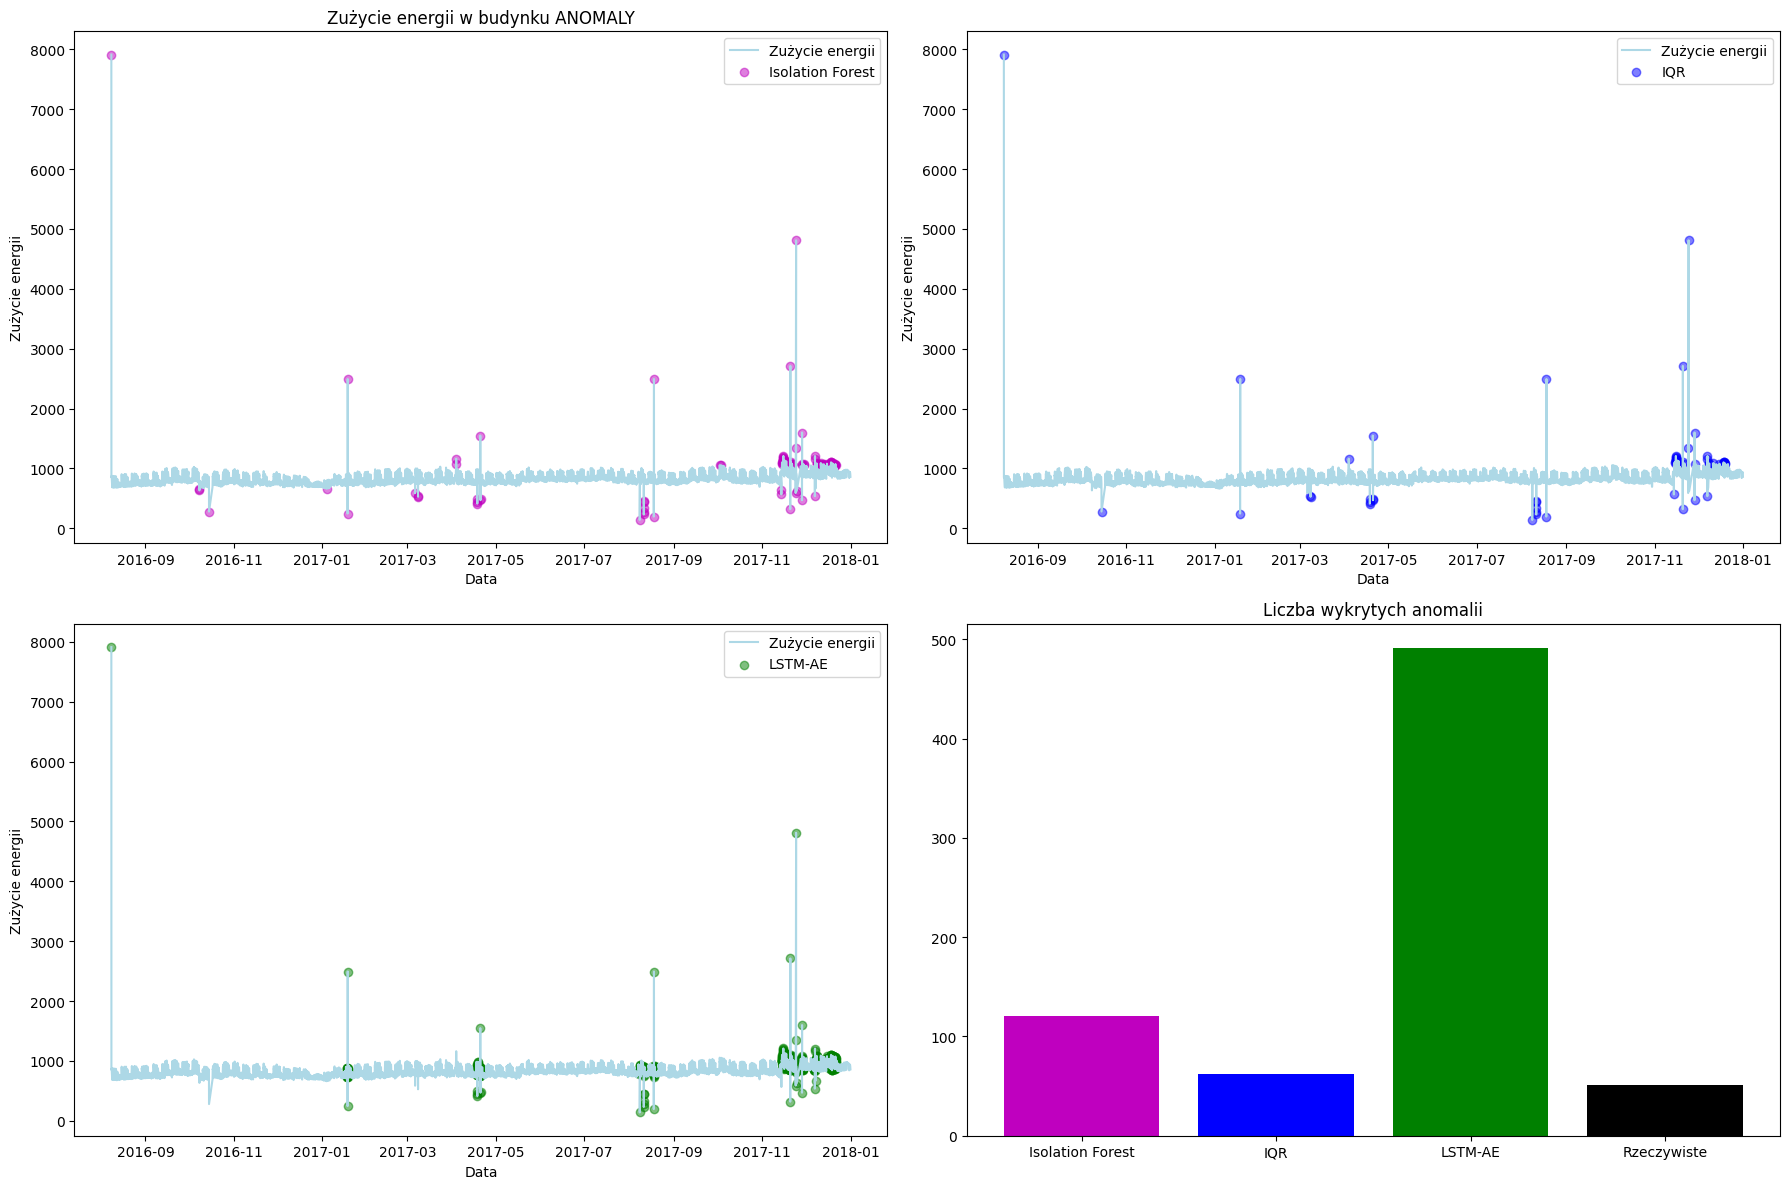

In [42]:
plots(d2,resIF2, resLSTM2, resIQR2)

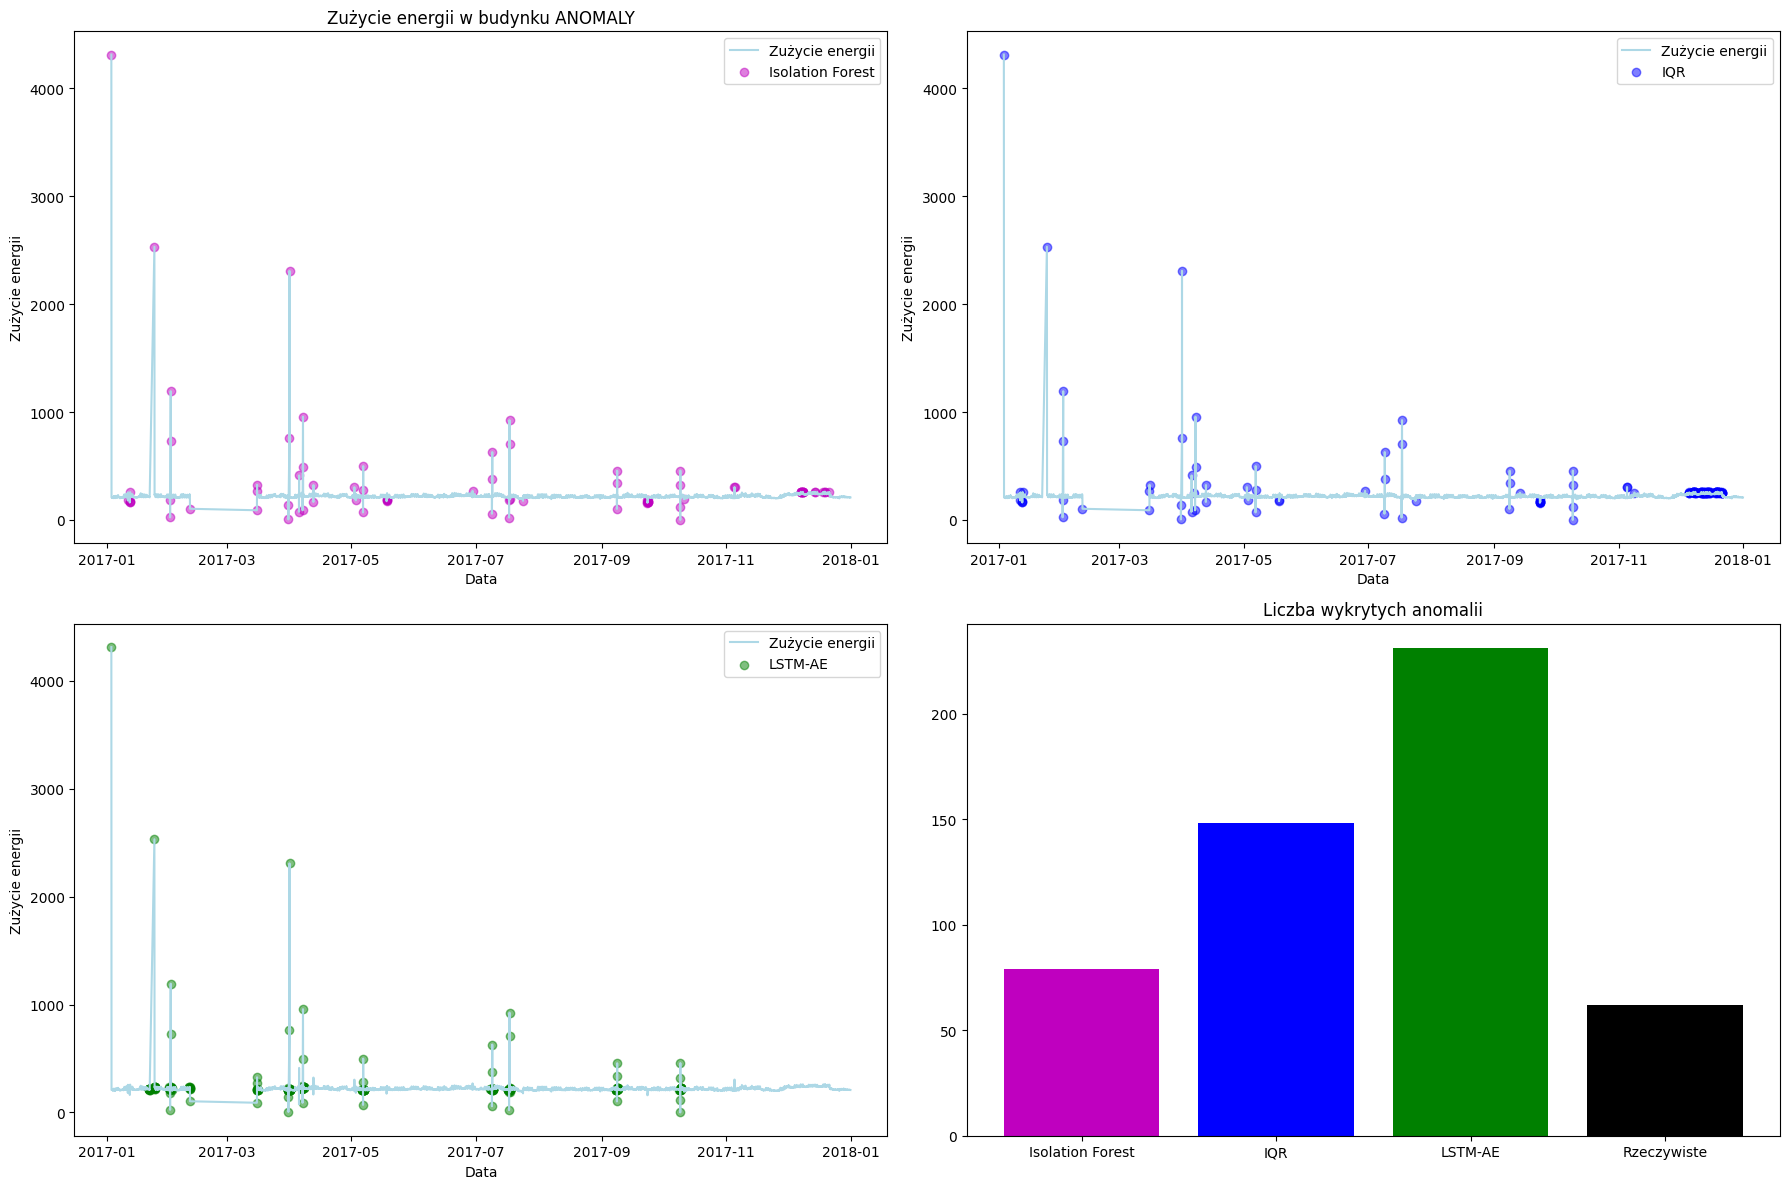

In [43]:
plots(d3,resIF3, resLSTM3, resIQR3)

In [18]:
def counter(data, IF, LSTM, IQR, bn):
    print(f"=========== Wyniki budynek {bn} ===========")
    ans = dict()

    for k, m in {"IF": IF[IF['isolation_forest'] == 1], "LSTM": LSTM[LSTM['lstm_autoencoder'] == 1],"IQR": data[IQR]}.items():
        TP = 0

        for i in list(m.index):
            if i in list(data[data['anomaly'] == True].index):
                TP+=1

        FP = len(list(m.index)) - TP
        FN = len(list(data[data['anomaly'] == True].index)) - TP
        TN = len(data) - TP - FN - FP
        print(f"Liczba anomalii wykrytych przez {k}: {TP}/{len(data[data['anomaly'] == True].index)}")
        print(f"Liczba anomalii wykrytych przez {k} spoza zakresu: {len(list(m.index)) - TP}")

        ans[k] = [TP, FP, FN, TN]
    return ans

b1 = counter(d,resIF,resLSTM,resIQR,1)
b2 = counter(d2,resIF2,resLSTM2,resIQR2,2)
b3 = counter(d3,resIF3,resLSTM3,resIQR3,3)

=========== Wyniki budynek 1 ===========
Liczba anomalii wykrytych przez IF: 39/39
Liczba anomalii wykrytych przez IF spoza zakresu: 131
Liczba anomalii wykrytych przez LSTM: 31/39
Liczba anomalii wykrytych przez LSTM spoza zakresu: 255
Liczba anomalii wykrytych przez IQR: 39/39
Liczba anomalii wykrytych przez IQR spoza zakresu: 3
=========== Wyniki budynek 2 ===========
Liczba anomalii wykrytych przez IF: 51/51
Liczba anomalii wykrytych przez IF spoza zakresu: 70
Liczba anomalii wykrytych przez LSTM: 42/51
Liczba anomalii wykrytych przez LSTM spoza zakresu: 449
Liczba anomalii wykrytych przez IQR: 45/51
Liczba anomalii wykrytych przez IQR spoza zakresu: 17
=========== Wyniki budynek 3 ===========
Liczba anomalii wykrytych przez IF: 62/62
Liczba anomalii wykrytych przez IF spoza zakresu: 17
Liczba anomalii wykrytych przez LSTM: 34/62
Liczba anomalii wykrytych przez LSTM spoza zakresu: 197
Liczba anomalii wykrytych przez IQR: 60/62
Liczba anomalii wykrytych przez IQR spoza zakresu: 88


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def calculate_metrics(tp, fp, fn, tn):
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1 Score': f1_score
    }

def create_metrics_dataframe(metrics_dict):
    df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Value'])
    df['Value'] = df['Value'].map('{:.4f}'.format)  # Formatowanie do 4 miejsc po przecinku
    return df


df = pd.DataFrame()
for bb in [b1,b2,b3]:
    for x in ['IF', 'LSTM', 'IQR']:
        tp, fp, fn, tn = bb[x]
        metrics = calculate_metrics(tp, fp, fn, tn)
        df[x] = metrics

    # Wyświetlanie wyników
    print("\nMetryki oceny modelu:")
    print("---------------------")
    print(df)



Metryki oceny modelu:
---------------------
                            IF      LSTM       IQR
Accuracy              0.992313  0.984568  0.999824
Precision             0.229412  0.108392  0.928571
Recall (Sensitivity)  1.000000  0.794872  1.000000
Specificity           0.992295  0.985003  0.999824
F1 Score              0.373206  0.190769  0.962963

Metryki oceny modelu:
---------------------
                            IF      LSTM       IQR
Accuracy              0.994196  0.962023  0.998093
Precision             0.421488  0.085540  0.725806
Recall (Sensitivity)  1.000000  0.823529  0.882353
Specificity           0.994171  0.962611  0.998584
F1 Score              0.593023  0.154982  0.796460

Metryki oceny modelu:
---------------------
                            IF      LSTM       IQR
Accuracy              0.997827  0.971239  0.988495
Precision             0.784810  0.147186  0.405405
Recall (Sensitivity)  1.000000  0.548387  0.967742
Specificity           0.997810  0.974617  0.98866

In [50]:
# Funkcja do przypisywania etykiet zgodności metod
def assign_consensus_labels(if_res, lstm_res, iqr_res):
    consensus = pd.DataFrame(index=if_res.index)

    consensus['low'] = if_res  # Tylko Isolation Forest
    consensus['medium'] = if_res & (iqr_res | lstm_res) # IF + 1 inna metoda
    consensus['high'] = if_res & lstm_res & iqr_res  # Wszystkie 3 metody
    return consensus

def plotAll(dat, IF, LSTM, IQR):
    plt.figure(figsize=(16, 10))
    

    consensus = assign_consensus_labels(
        IF['isolation_forest'] == 1,
        LSTM['lstm_autoencoder'] == 1,
        IQR
    )

    # Zaznaczanie anomalii według poziomów pewności
    low_anomalies = dat.loc[consensus['low'] & ~consensus['medium']]
    medium_anomalies = dat.loc[consensus['medium'] & ~consensus['high']]
    high_anomalies = dat.loc[consensus['high']]

    plt.subplot(2,1,1)
    plt.plot(dat.index, dat['energy_consumption'], label='Zużycie energii', color='lightblue', alpha=0.7)
    plt.scatter(low_anomalies.index, low_anomalies['energy_consumption'],
                label="Niska pewność", color='yellow', alpha=0.9, marker='o')

    plt.scatter(medium_anomalies.index, medium_anomalies['energy_consumption'],
                label="Średnia pewność", color='orange', alpha=0.9, marker='^')

    plt.scatter(high_anomalies.index, high_anomalies['energy_consumption'],
                label="Wysoka pewność", color='red', alpha=0.9, marker='s')

    plt.title('Zużycie energii z anomaliami według poziomów pewności')
    plt.legend()

    counts = {
        'Isolation Forest': sum(IF['isolation_forest'] == 1),
        'IQR': sum(IQR),
        'LSTM-AE': sum(LSTM['lstm_autoencoder'] == 1),
        'Niska pewność': sum(consensus['low'] & ~consensus['medium']),
        'Średnia pewność': sum(consensus['medium'] & ~consensus['high']),
        'Wysoka pewność': sum(consensus['high'])
    }

    real = dat[dat['anomaly']==True].count()

    colors = ['violet', 'lightblue', 'lightgreen', 'yellow', 'orange', 'red']
    plt.subplot(2,1,2)
    plt.bar(counts.keys(), counts.values(), color=colors)
    plt.bar("Rzeczywiste", real,color="black")
    plt.title('Porównanie liczby wykrytych anomalii')
    plt.ylabel('Liczba anomalii')
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()

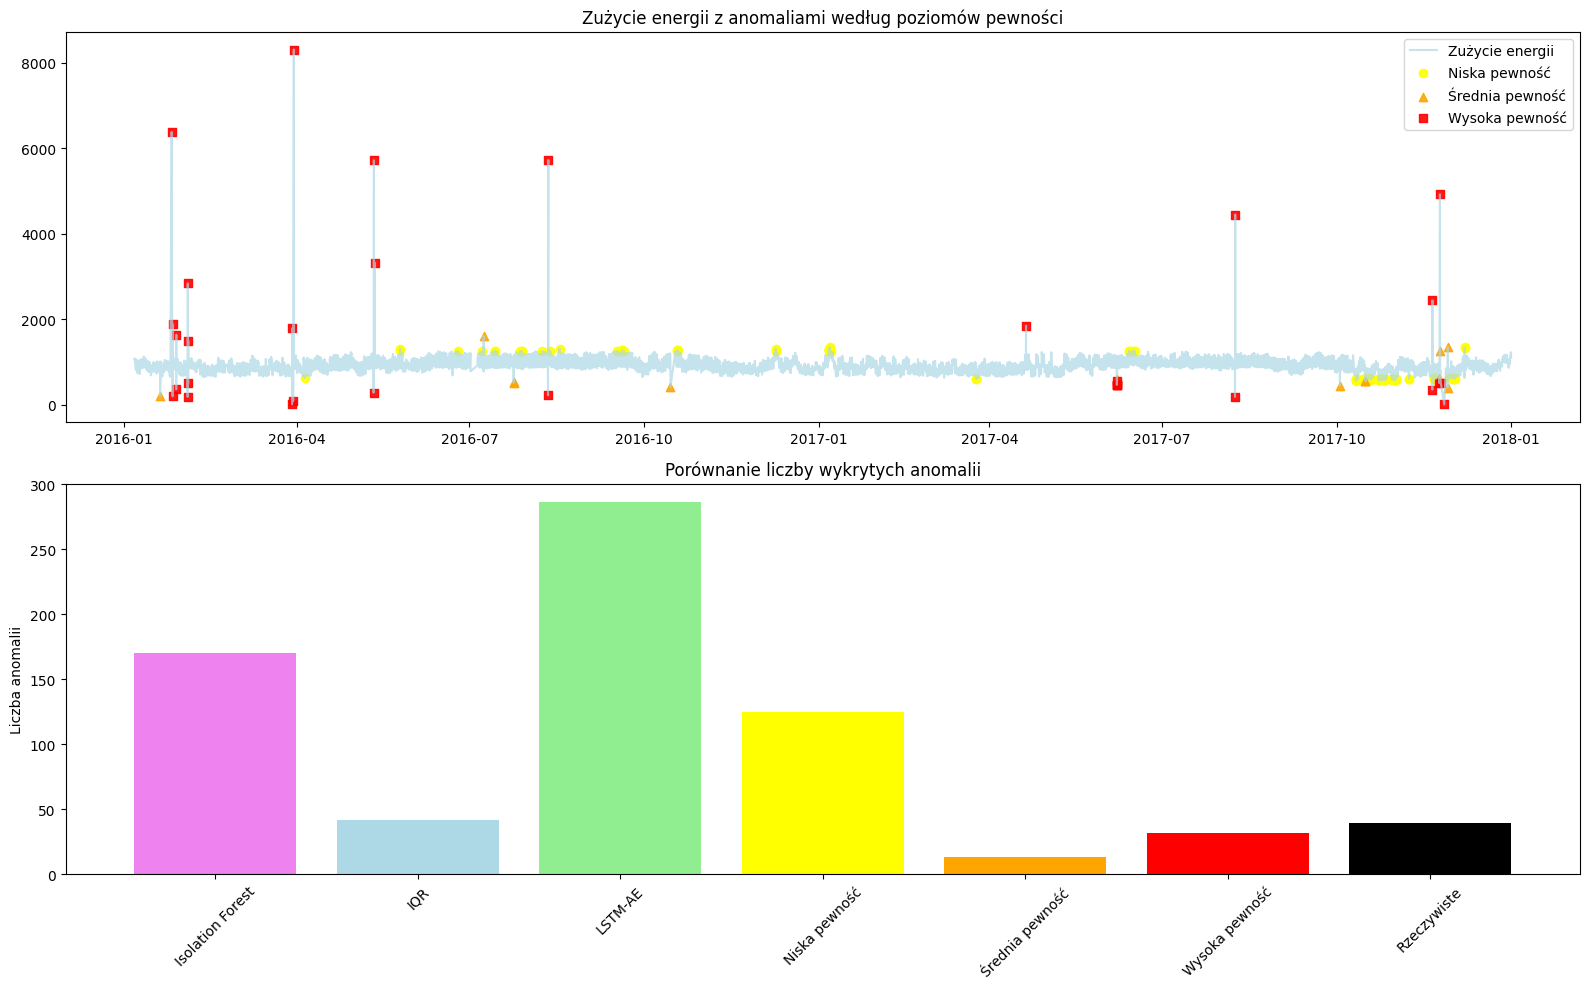

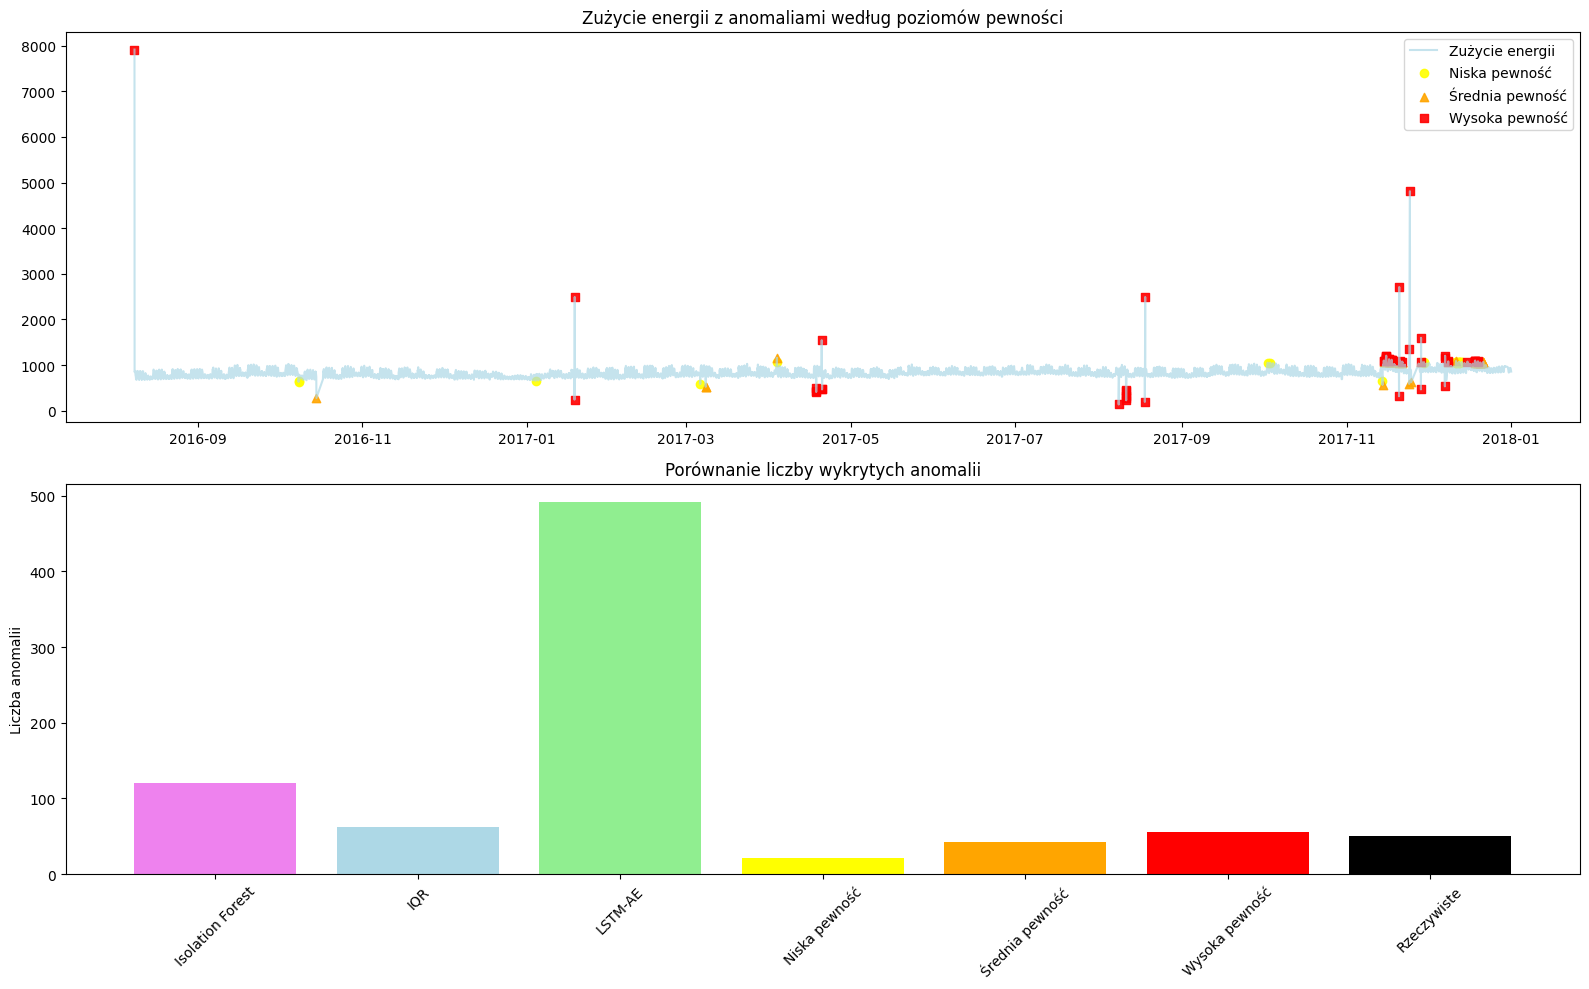

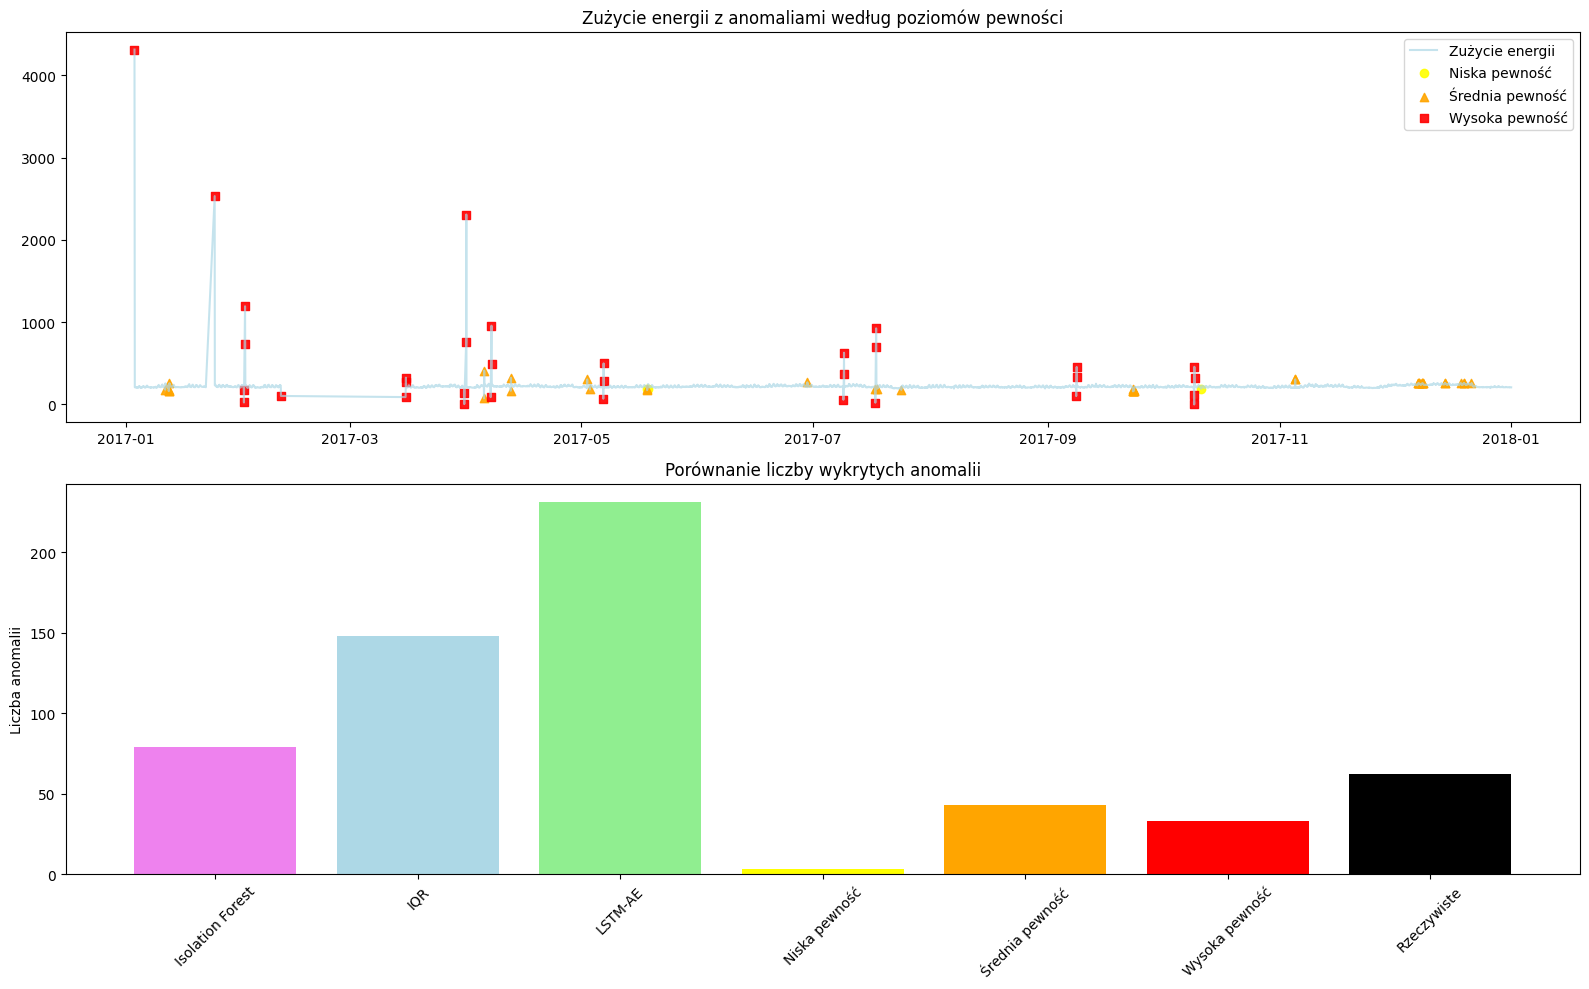

In [51]:
plotAll(d, resIF, resLSTM, resIQR)
plotAll(d2, resIF2, resLSTM2, resIQR2)
plotAll(d3, resIF3, resLSTM3, resIQR3)

In [ ]:
# Funkcja do przypisywania etykiet zgodności metod
def matcher(if_res, lstm_res, iqr_res):
    consensus = pd.DataFrame(index=if_res.index)
    if_res = if_res.astype(bool) if if_res is not None else pd.Series(False, index=consensus.index)
    lstm_res = lstm_res.astype(bool) if lstm_res is not None else pd.Series(False, index=consensus.index)
    iqr_res = iqr_res.astype(bool) if iqr_res is not None else pd.Series(False, index=consensus.index)
    
    # Pojedyncze modele
    consensus['IF'] = if_res
    consensus['IQR'] = iqr_res
    consensus['LSTM'] = lstm_res
    
    # Części wspólne (intersections – AND)
    consensus['IQR+IF'] = iqr_res & if_res
    consensus['LSTM+IF'] = lstm_res & if_res
    consensus['Wszystkie'] = if_res & iqr_res & lstm_res

    # Unie (unions – OR)
    consensus['IQR|IF'] = iqr_res | if_res
    consensus['LSTM|IF'] = if_res | lstm_res
    consensus['Jakikolwiek'] = if_res | iqr_res | lstm_res
    return consensus


def isBetter(dat, IF, LSTM, IQR):    
    consensus = matcher(
        IF['isolation_forest'] == 1,
        LSTM['lstm_autoencoder'] == 1,
        IQR
    )

    TP = 0



    df = pd.DataFrame()
    for c in list(consensus.columns):
        TP = 0
        for i in list(consensus[c][consensus[c]==True].index):
            if i in list(dat['anomaly'][dat['anomaly']== True].index):
                TP+=1
        
        print(c)
        print("TP", TP)
        FP = len(list(consensus[c][consensus[c]==True].index))-TP
        print("FP", FP)
        FN = len(list(dat['anomaly'][dat['anomaly']== True].index))-TP
        print("FN",  FN)
        TN = len(dat) - FN - FP - TP
        print("TN", TN)
        print("------------------------------")

        df[c] = [TP, FP, FN, TN]

    return df


s1 = isBetter(d,resIF,resLSTM,resIQR)
print("=================================")
s2 = isBetter(d2,resIF2,resLSTM2,resIQR2)
print("=================================")
s3 = isBetter(d3,resIF3,resLSTM3,resIQR3)

IF
TP 39
FP 129
FN 0
TN 16874
------------------------------
IQR
TP 39
FP 3
FN 0
TN 17000
------------------------------
LSTM
TP 31
FP 251
FN 8
TN 16752
------------------------------
IQR+IF
TP 39
FP 3
FN 0
TN 17000
------------------------------
LSTM+IF
TP 31
FP 4
FN 8
TN 16999
------------------------------
Wszystkie
TP 31
FP 1
FN 8
TN 17002
------------------------------
IQR|IF
TP 39
FP 129
FN 0
TN 16874
------------------------------
LSTM|IF
TP 39
FP 376
FN 0
TN 16627
------------------------------
Jakikolwiek
TP 39
FP 376
FN 0
TN 16627
------------------------------
IF
TP 51
FP 69
FN 0
TN 11940
------------------------------
IQR
TP 45
FP 17
FN 6
TN 11992
------------------------------
LSTM
TP 45
FP 386
FN 6
TN 11623
------------------------------
IQR+IF
TP 45
FP 17
FN 6
TN 11992
------------------------------
LSTM+IF
TP 45
FP 25
FN 6
TN 11984
------------------------------
Wszystkie
TP 43
FP 9
FN 8
TN 12000
------------------------------
IQR|IF
TP 51
FP 69
FN 0
TN 11940
----------

In [ ]:
df = pd.DataFrame()

for ss in [s1,s2,s3]:
    for x in ['IF', 'IQR', 'LSTM', 'IQR+IF', 'LSTM|IF', "Wszystkie", 'IQR|IF', 'LSTM|IF',"Jakikolwiek"]:
        tp, fp, fn, tn = ss[x]
        metrics = calculate_metrics(tp, fp, fn, tn)
        df[x] = metrics

    # Wyświetlanie wyników
    print("\nMetryki oceny modelu:")
    print("---------------------")
    print(df)


Metryki oceny modelu:
---------------------
                            IF       IQR      LSTM    IQR+IF   LSTM|IF  \
Accuracy              0.992430  0.999824  0.984802  0.999824  0.977937   
Precision             0.232143  0.928571  0.109929  0.928571  0.093976   
Recall (Sensitivity)  1.000000  1.000000  0.794872  1.000000  1.000000   
Specificity           0.992413  0.999824  0.985238  0.999824  0.977886   
F1 Score              0.376812  0.962963  0.193146  0.962963  0.171806   

                      Wszystkie    IQR|IF  Jakikolwiek  
Accuracy               0.999472  0.992430     0.977937  
Precision              0.968750  0.232143     0.093976  
Recall (Sensitivity)   0.794872  1.000000     1.000000  
Specificity            0.999941  0.992413     0.977886  
F1 Score               0.873239  0.376812     0.171806  

Metryki oceny modelu:
---------------------
                            IF       IQR      LSTM    IQR+IF   LSTM|IF  \
Accuracy              0.994279  0.998093  0.96749

### Test nieanomalii

In [ ]:
ttdf = pd.read_csv("test20set.csv")

ttdf['building_id'].unique()

C:\Users\Julia\AppData\Local\Temp\ipykernel_21996\2164800340.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  ttdf = pd.read_csv("test20set.csv")


array(['Bear_assembly_Jose', 'Eagle_health_Reuben',
       'Fox_assembly_Christie', 'Fox_parking_Lynelle',
       'Hog_office_Alexis', 'Hog_office_Guadalupe', 'Hog_office_Leanne',
       'Hog_office_Leon', 'Hog_office_Mari', 'Peacock_education_Yolanda',
       'Peacock_office_Julian', 'Rat_assembly_Deandre',
       'Rat_education_Esther', 'Rat_public_Angelina', 'Rat_public_Clyde',
       'Rat_public_Leo', 'Rat_public_Shanta', 'Rat_public_Tamra',
       'Wolf_education_Tori', 'Wolf_retail_Toshia'], dtype=object)

In [ ]:
d4 = load_and_preprocess('anomaly_three.csv')
d4 = test
d4_lstm4 = d4
resIF4 = universal_isolation_forest(data=d4)
# resLSTM4 = lstm_autoencoder(d4_lstm4, window_size=24, iqr_multiplier=4.5)
t4, resIQR4 = dynamic_iqr(d4['energy_consumption'], w=None, k=1.5)



In [ ]:
n = 0
plotAll(d4[-n:], resIF4[-n:], resLSTM4[-n:], resIQR4[-n:])

Error in callback <function _draw_all_if_interactive at 0x0000017CDCE57BA0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

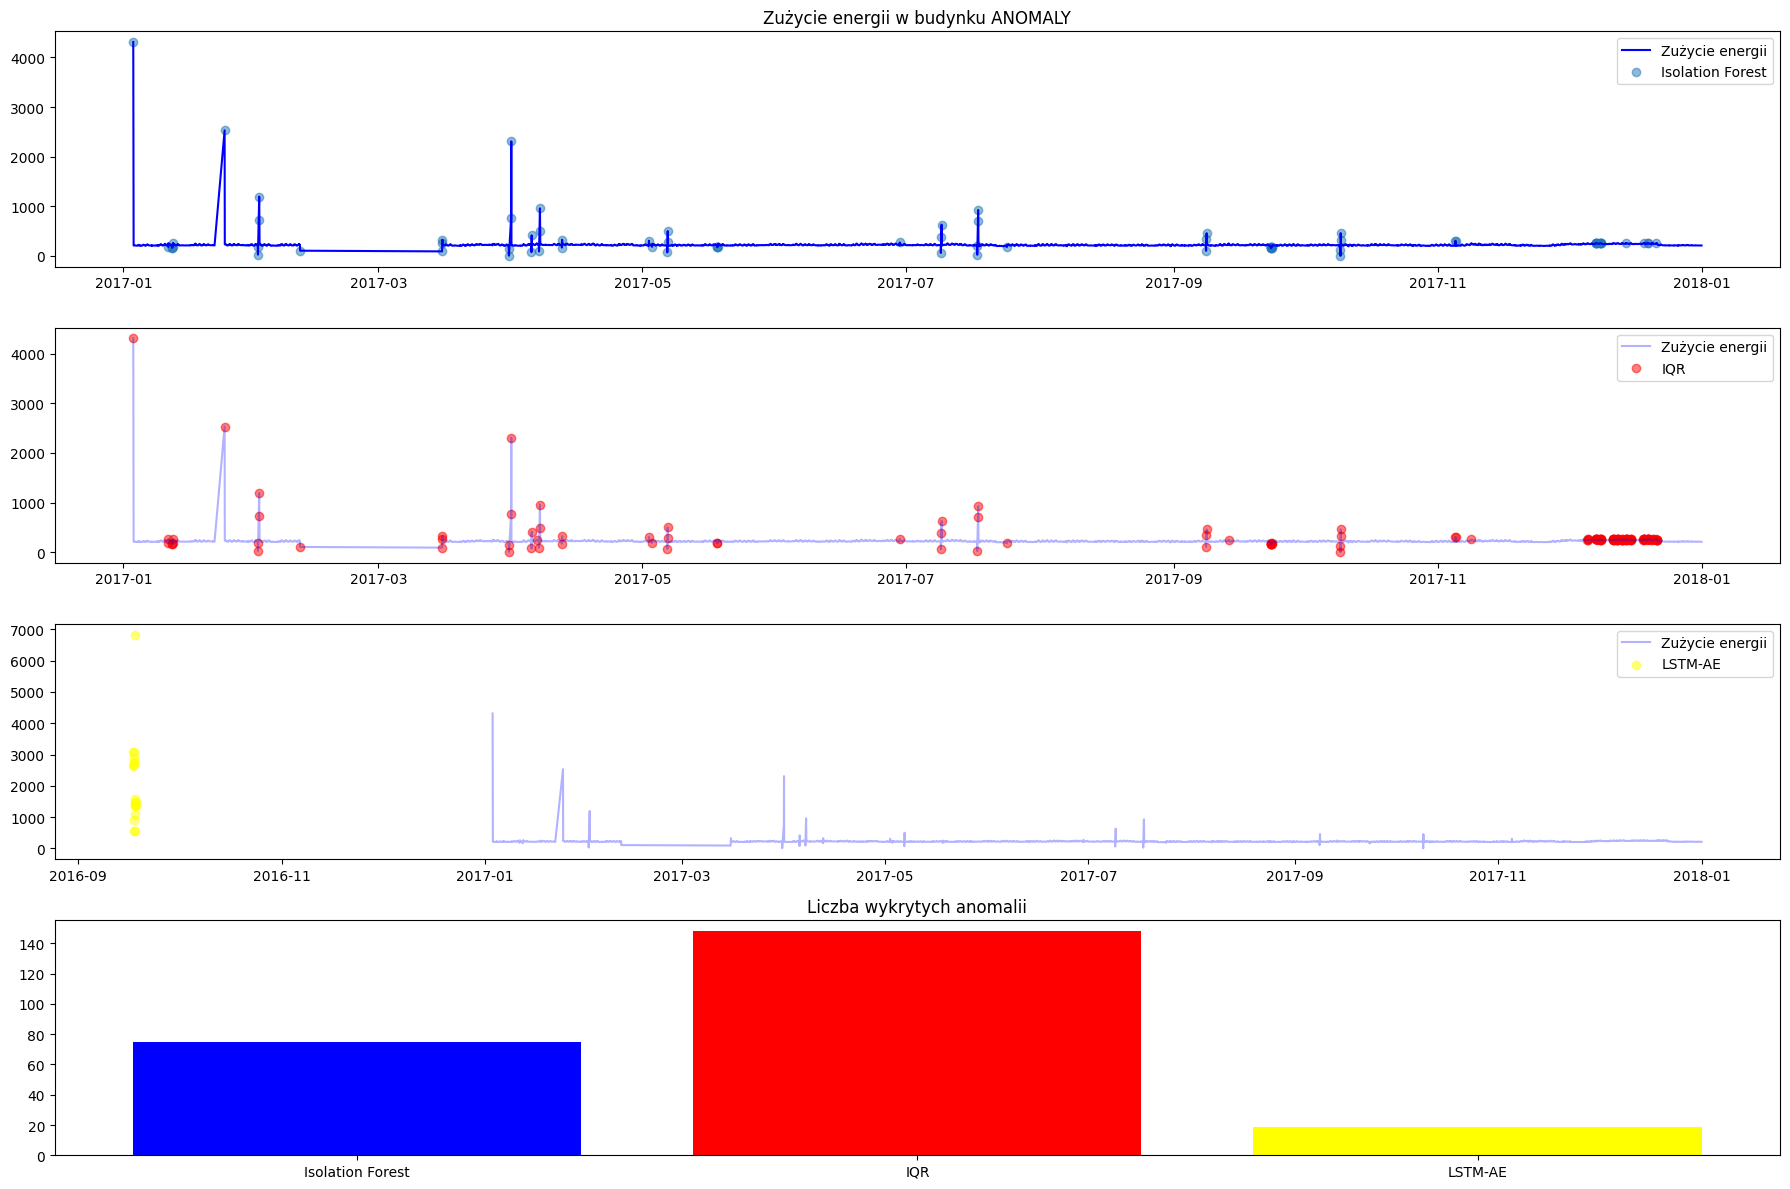

In [ ]:
plots(d4, resIF4, resLSTM4, resIQR4)

In [ ]:
# Funkcja do przypisywania etykiet zgodności metod
def assign_consensus_labels(if_res, lstm_res, iqr_res):
    consensus = pd.DataFrame(index=if_res.index)
    
    # Konwersja do typu bool z zabezpieczeniem przed brakującymi wartościami
    if_res = if_res.astype(bool) if if_res is not None else pd.Series(False, index=consensus.index)
    lstm_res = lstm_res.astype(bool) if lstm_res is not None else pd.Series(False, index=consensus.index)
    iqr_res = iqr_res.astype(bool) if iqr_res is not None else pd.Series(False, index=consensus.index)
    
    consensus['low'] = if_res  # Tylko Isolation Forest
    consensus['IF/LSTM'] = if_res & lstm_res  # IF + 1 inna metoda
    consensus['IF/IQR'] = if_res & iqr_res  # IF + 1 inna metoda
    consensus['high'] = if_res & lstm_res & iqr_res  # Wszystkie 3 metody
    return consensus

In [ ]:
consensus = assign_consensus_labels(
        resIF4['isolation_forest'] == 1,
        resLSTM4['lstm_autoencoder'] == 1,
        resIQR4
    )
consensus

,low,IF/LSTM,IF/IQR,high
timestamp,,,,
2016-01-06 11:00:00,False,False,False,False
2016-01-06 12:00:00,False,False,False,False
2016-01-06 13:00:00,False,False,False,False
2016-01-06 14:00:00,False,False,False,False
2016-01-06 15:00:00,False,False,False,False
...,...,...,...,...
2017-12-31 19:00:00,False,False,False,False
2017-12-31 20:00:00,False,False,False,False
2017-12-31 21:00:00,False,False,False,False


KeyError: 'IF/IQR'

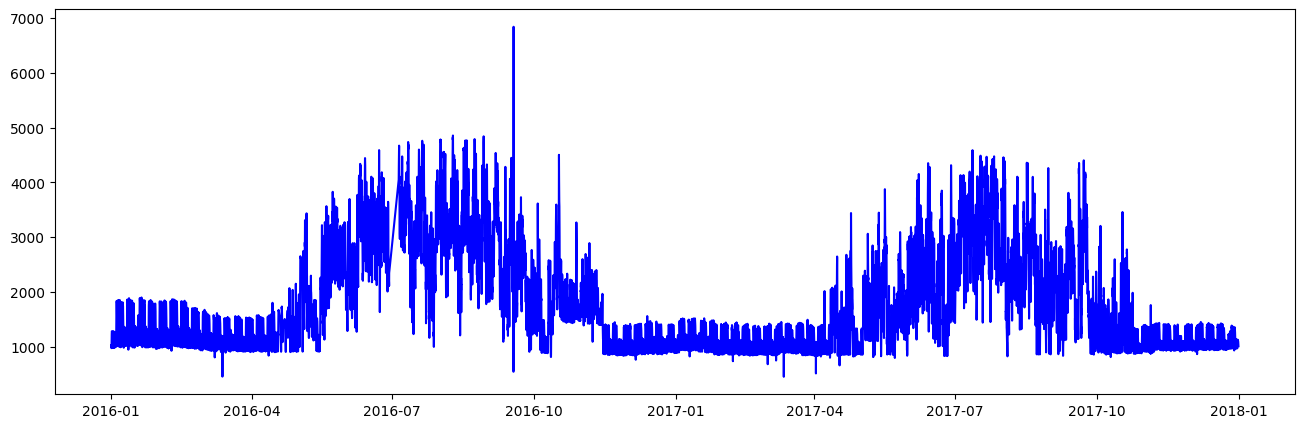

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(d4.index, d4['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(consensus['IF/IQR'][consensus['IF/IQR']==True].index, d4[consensus['IF/IQR']==True]['energy_consumption'],label="Isolation Forest + IQR", alpha=0.5, color="red")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()

plt.figure(figsize=(16,5))
plt.plot(d4.index, d4['energy_consumption'], label='Zużycie energii', color='blue')
plt.scatter(consensus['IF/LSTM'][consensus['IF/LSTM']==True].index, d4[consensus['IF/LSTM']==True]['energy_consumption'],label="LSTM-AE + IQR", alpha=0.5, color="green")
plt.title(f'Zużycie energii w budynku ANOMALY')
plt.legend()



In [ ]:

c = 0

for i in list(consensus['IF/LSTM'].index):
    if i in list(d4[d4['anomaly'] == True].index):
        c+=1

print(f"Liczba anomalii wykrytych przez IQR: {c}/{len(d4[d4['anomaly'] == True].index)}")
print(f"Liczba anomalii wykrytych przez IQR spoza zakresu: {len(list(t4[resIQR4].index)) - c}")

Liczba anomalii wykrytych przez IQR: 39/39
Liczba anomalii wykrytych przez IQR spoza zakresu: 3


In [ ]:
c=0
for i in d4['anomaly'][d4['anomaly'] == True].index:
    if i in consensus['IF/IQR'][consensus['IF/IQR']==True].index:
        c+=1

print(c, "/", len(d4['anomaly'][d4['anomaly'] == True].index))
print(len(consensus['IF/IQR'][consensus['IF/IQR']==True].index))

39 / 39
42


In [52]:
def detect_anomaly(data):
    d = data.set_index("timestamp")
    resIF = isolation_forest_IQR(data=d)
    resIQR = dynamic_iqr(d['energy_consumption'], w=None, k=1.5)
    last = (d.index.iloc[-1] in resIF[resIF['isolation_forest']=="True"]) | (d.index.iloc[-1] in d[resIQR])

    result = {"low": resIF, "medium": resIF & resIQR, "last": last}

    return result

detect_anomaly(d)

KeyError: "None of ['timestamp'] are in the columns"